In [3]:
!pip install catboost

In [4]:
%matplotlib inline
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [5]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json


In [6]:
!pip install --upgrade plotly jupyter

In [7]:
import plotly.io as pio
pio.renderers.default = 'browser'  # or 'svg' / 'chrome' / etc.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

=== Step 1: Fetching Data ===
Fetching data for EURUSD=X from 2000-01-01 to 2025-02-09 ...
Saved EURUSD.csv to data/
Fetching data for GC=F from 2000-01-01 to 2025-02-09 ...


Saved Gold.csv to data/
Data fetching completed and saved to CSV.

=== Loading & Preprocessing ===

Loaded EURUSD.csv with shape (5500, 5)

Loaded Gold.csv with shape (6133, 5)

=== Step 2: Preprocessing Data ===
Saved EURUSD_features.csv to data/
Saved Gold_features.csv to data/

Loaded EURUSD_features.csv with shape (5498, 14)

Loaded Gold_features.csv with shape (6133, 14)

=== EDA for EURUSD ===
Head:
                Close      High       Low      Open  Volume  MA_20  MA_50  \
Date                                                                       
2003-12-01  1.196501  1.204007  1.194401  1.203398       0    NaN    NaN   
2003-12-02  1.208897  1.210903  1.194600  1.196101       0    NaN    NaN   
2003-12-03  1.212298  1.213003  1.207700  1.209000       0    NaN    NaN   
2003-12-04  1.208094  1.214403  1.204398  1.212004       0    NaN    NaN   
2003-12-05  1.218695  1.219096  1.206593  1.207802       0    NaN    NaN   

                   RSI  Bollinger_Upper  Bollinger_Lower 

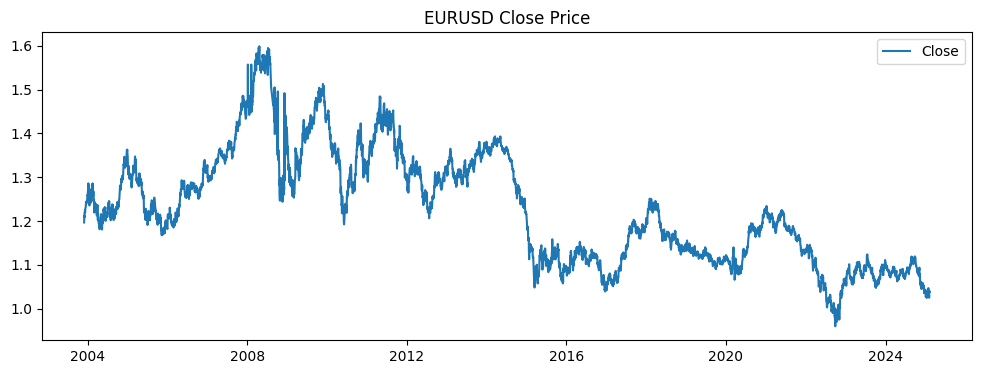


=== EDA for Gold ===
Head:
                  Close        High         Low        Open  Volume  MA_20  \
Date                                                                        
2000-08-30  273.899994  273.899994  273.899994  273.899994       0    NaN   
2000-08-31  278.299988  278.299988  274.799988  274.799988       0    NaN   
2000-09-01  277.000000  277.000000  277.000000  277.000000       0    NaN   
2000-09-05  275.799988  275.799988  275.799988  275.799988       2    NaN   
2000-09-06  274.200012  274.200012  274.200012  274.200012       0    NaN   

            MA_50         RSI  Bollinger_Upper  Bollinger_Lower      MACD  \
Date                                                                        
2000-08-30    NaN         NaN              NaN              NaN  0.000000   
2000-08-31    NaN  100.000000              NaN              NaN  0.350997   
2000-09-01    NaN   97.777795              NaN              NaN  0.518291   
2000-09-05    NaN   95.664472              NaN

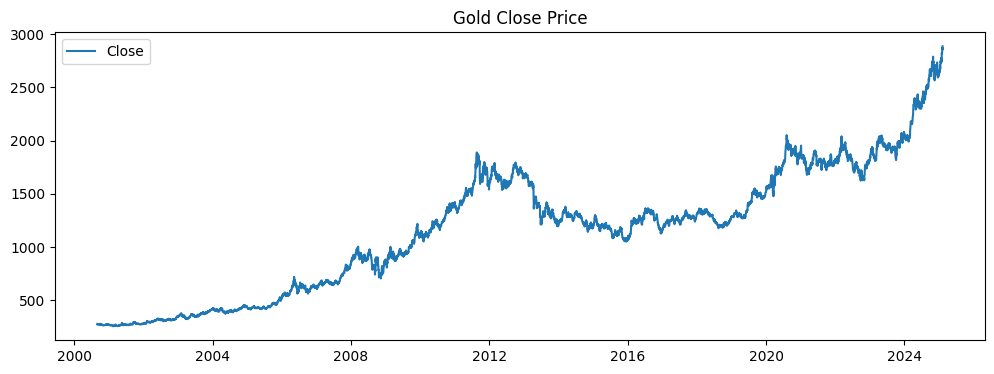


=== Market Analysis ===
Correlation between EURUSD & Gold: -0.4291

Granger causality test (max_lag=5):
  Lag 1: p-value = 0.0647
  Lag 2: p-value = 0.0000
  Lag 3: p-value = 0.0000
  Lag 4: p-value = 0.0000
  Lag 5: p-value = 0.0000

Cointegration test: t-stat=-2.5328, p-value=0.2648


=== Step 5: Modeling & Prediction ===
Train size: 4359, Test size: 1090


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
ARIMA -> RMSE: 0.1248, MAE: 0.1108, R2: -3.4152
RF    -> RMSE: 0.0183, MAE: 0.0095, R2: 0.9055
LSTM  -> RMSE: 0.0516, MAE: 0.0403, R2: 0.2453
Ensemble(ARIMA,RF) -> RMSE: 0.0683, MAE: 0.0587, R2: -0.3235

Trend-Following Backtest:
Sharpe: 0.0993, MaxDD: 0.1607, CAGR: 0.48%

=== Step 8: Visualization & Reporting ===



Backtest Results:
Sharpe: 0.0993, MaxDD: 0.1607, CAGR: 0.48%


In [8]:
!pip install yfinance xgboost catboost lightgbm shap plotly statsmodels tensorflow seaborn --quiet

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import coint, grangercausalitytests
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import warnings
warnings.filterwarnings("ignore")
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

#Global Configs
DATA_DIR = "data"

def fetch_data_from_yfinance(ticker: str, start: str, end: str) -> pd.DataFrame:
    print(f"Fetching data for {ticker} from {start} to {end} ...")
    df = yf.download(ticker, start=start, end=end)
    if df.empty:
        raise ValueError(f"No data found for ticker: {ticker}")
    df.index = pd.to_datetime(df.index)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df

def save_data_to_csv(df: pd.DataFrame, filename: str):
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
    file_path = os.path.join(DATA_DIR, filename)
    df.to_csv(file_path)
    print(f"Saved {filename} to {DATA_DIR}/")

def load_data_from_csv(filename: str) -> pd.DataFrame:
    file_path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(file_path):
        print(f"File {filename} does not exist in {DATA_DIR}. Returning empty DataFrame.")
        return pd.DataFrame()
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    print(f"\nLoaded {filename} with shape {df.shape}")
    df.columns = df.columns.str.strip()
    rename_map = {}
    for col in df.columns:
        if '_' in col and ('=X' in col or '=F' in col):
            main_col = col.split('_')[0]
            rename_map[col] = main_col
        else:
            rename_map[col] = col
    df.rename(columns=rename_map, inplace=True)
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    if 'Close' in df.columns:
        before = len(df)
        df.dropna(subset=['Close'], inplace=True)
        after = len(df)
        if before != after:
            print(f"Dropped {before - after} rows due to NaN in 'Close' column.")
    return df

def main_data_fetching():
    print("=== Step 1: Fetching Data ===")
    start_date = "2000-01-01"
    end_date = datetime.now().strftime("%Y-%m-%d")
    try:
        eurusd_df = fetch_data_from_yfinance("EURUSD=X", start=start_date, end=end_date)
        save_data_to_csv(eurusd_df, "EURUSD.csv")
    except Exception as e:
        print(f"Error fetching EUR/USD data: {e}")
    try:
        gold_df = fetch_data_from_yfinance("GC=F", start=start_date, end=end_date)
        save_data_to_csv(gold_df, "Gold.csv")
    except Exception as e:
        print(f"Error fetching Gold data: {e}")
    print("Data fetching completed and saved to CSV.")

def clean_and_preprocess_data(df: pd.DataFrame, fill_method: str = 'ffill', drop_duplicates: bool = True, remove_outliers_zscore: float = None, scale_method: str = None) -> pd.DataFrame:
    df = df.copy()
    if drop_duplicates:
        df = df[~df.index.duplicated(keep='first')]
    if fill_method == 'ffill':
        df.fillna(method='ffill', inplace=True)
    elif fill_method == 'bfill':
        df.fillna(method='bfill', inplace=True)
    elif fill_method == 'mean':
        df.fillna(df.mean(), inplace=True)
    if remove_outliers_zscore is not None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Volume', errors='ignore')
        if len(numeric_cols) > 0:
            z_scores = np.abs(zscore(df[numeric_cols]))
            z_scores = np.nan_to_num(z_scores, nan=np.inf, posinf=np.inf, neginf=np.inf)
            df = df[(z_scores < remove_outliers_zscore).all(axis=1)]
    if scale_method:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if scale_method == 'standard':
            scaler = StandardScaler()
            df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
        elif scale_method == 'minmax':
            scaler = MinMaxScaler()
            df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if 'Close' not in df.columns:
        print("No 'Close' column found. Cannot add technical indicators.")
        return df
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    window_length = 14
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=window_length - 1, adjust=False).mean()
    ema_down = down.ewm(com=window_length - 1, adjust=False).mean()
    rs = ema_up / ema_down
    df['RSI'] = 100 - (100 / (1 + rs))
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = rolling_mean + (rolling_std * 2)
    df['Bollinger_Lower'] = rolling_mean - (rolling_std * 2)
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window=20).std() * np.sqrt(20)
    return df

def main_data_preprocessing(eurusd_df, gold_df):
    print("\n=== Step 2: Preprocessing Data ===")
    eurusd_cleaned = clean_and_preprocess_data(eurusd_df, fill_method='ffill', drop_duplicates=True, remove_outliers_zscore=3.0, scale_method=None)
    eurusd_features = add_technical_indicators(eurusd_cleaned)
    eurusd_features.dropna(subset=['Close'], inplace=True)
    save_data_to_csv(eurusd_features, "EURUSD_features.csv")
    gold_cleaned = clean_and_preprocess_data(gold_df, fill_method='ffill', drop_duplicates=True, remove_outliers_zscore=3.0, scale_method=None)
    gold_features = add_technical_indicators(gold_cleaned)
    gold_features.dropna(subset=['Close'], inplace=True)
    save_data_to_csv(gold_features, "Gold_features.csv")

def exploratory_data_analysis(df: pd.DataFrame, asset_name: str):
    if df.empty:
        print(f"{asset_name} DataFrame is empty. Skipping EDA.")
        return
    print(f"\n=== EDA for {asset_name} ===")
    print("Head:\n", df.head())
    print("\nStats:\n", df.describe())
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df['Close'], label='Close')
    plt.title(f'{asset_name} Close Price')
    plt.legend()
    plt.show()
    corr = df.corr(numeric_only=True)
    fig = px.imshow(corr, text_auto=True, aspect="auto", title=f"{asset_name} Correlation Matrix")
    fig.show()

def market_analysis(df1: pd.DataFrame, df2: pd.DataFrame, col_name: str = "Close", label1: str = "EURUSD", label2: str = "Gold"):
    print("\n=== Market Analysis ===")
    merged = pd.DataFrame()
    merged[label1] = df1[col_name]
    merged[label2] = df2[col_name]
    merged.dropna(inplace=True)
    if merged.empty:
        print("Merged DataFrame is empty; cannot analyze.")
        return
    corr_val = merged.corr().iloc[0, 1]
    print(f"Correlation between {label1} & {label2}: {corr_val:.4f}")
    max_lag = 5
    print(f"\nGranger causality test (max_lag={max_lag}):")
    try:
        results = grangercausalitytests(merged[[label1, label2]], maxlag=max_lag, verbose=False)
        for lag, res in results.items():
            p_value = res[0]['ssr_ftest'][1]
            print(f"  Lag {lag}: p-value = {p_value:.4f}")
    except Exception as e:
        print(f"Error in Granger causality: {e}")
    try:
        coint_score, p_value, _ = coint(merged[label1], merged[label2])
        print(f"\nCointegration test: t-stat={coint_score:.4f}, p-value={p_value:.4f}\n")
    except Exception as e:
        print(f"Error in cointegration test: {e}")

def train_test_split_time_series(df, test_size=0.2):
    split_index = int(len(df) * (1 - test_size))
    train_df = df.iloc[:split_index].copy()
    test_df = df.iloc[split_index:].copy()
    return train_df, test_df

def evaluate_predictions(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

def arima_model(train, test, order=(1,1,1), col_name='Close'):
    model = ARIMA(train[col_name], order=order).fit()
    preds = model.forecast(steps=len(test))
    return preds

def random_forest_model(train, test, features, target='Close'):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(train[features], train[target])
    preds = rf.predict(test[features])
    return preds

def prepare_sequence_data(df, features, target, window_size=10):
    X_list, y_list = [], []
    for i in range(window_size, len(df)):
        X_list.append(df[features].iloc[i-window_size:i].values)
        y_list.append(df[target].iloc[i])
    return np.array(X_list), np.array(y_list)

def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def deep_learning_model(train, test, features, target='Close', epochs=10, window_size=10):
    X_train, y_train = prepare_sequence_data(train, features, target, window_size)
    X_test, y_test = prepare_sequence_data(test, features, target, window_size)
    model = build_lstm((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)
    preds = model.predict(X_test).flatten()
    return preds, y_test

def ensemble_predictions(pred_list, weights=None):
    preds_arr = np.array(pred_list)
    if weights is None:
        weights = [1.0 / len(pred_list)] * len(pred_list)
    return np.tensordot(preds_arr, weights, axes=((0), (0)))

def main_modeling(eurusd_df):
    print("\n=== Step 5: Modeling & Prediction ===")
    if eurusd_df.empty or 'Close' not in eurusd_df.columns:
        print("EUR/USD DataFrame is empty or missing 'Close'. Skipping modeling.")
        return None, None, None, None, None
    features = ['MA_20', 'MA_50', 'RSI', 'MACD', 'Signal', 'Volatility']
    for f in features:
        if f not in eurusd_df.columns:
            print(f"Missing feature {f} in EURUSD DataFrame. Check preprocessing.")
            return None, None, None, None, None
    eurusd_df.dropna(subset=features + ['Close'], inplace=True)
    train_df, test_df = train_test_split_time_series(eurusd_df, test_size=0.2)
    print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
    try:
        arima_preds = arima_model(train_df, test_df, order=(2,1,2), col_name='Close')
    except Exception as e:
        print(f"ARIMA failed: {e}")
        arima_preds = None
    try:
        rf_preds = random_forest_model(train_df, test_df, features, target='Close')
    except Exception as e:
        print(f"RandomForest failed: {e}")
        rf_preds = None
    try:
        lstm_preds, y_test_lstm = deep_learning_model(train_df, test_df, features, target='Close', epochs=10, window_size=10)
        aligned_test_df = test_df.iloc[10:].copy()
    except Exception as e:
        print(f"LSTM failed: {e}")
        lstm_preds, aligned_test_df, y_test_lstm = None, None, None
    ensemble_preds = None
    if arima_preds is not None and rf_preds is not None:
        if aligned_test_df is not None:
            arima_aligned = arima_preds[10:]
            rf_aligned = rf_preds[10:]
            ensemble_preds = ensemble_predictions([arima_aligned, rf_aligned], weights=[0.5, 0.5])
        else:
            ensemble_preds = ensemble_predictions([arima_preds, rf_preds], weights=[0.5, 0.5])
    if arima_preds is not None:
        if aligned_test_df is not None:
            a_rmse, a_mae, a_r2 = evaluate_predictions(aligned_test_df['Close'], arima_preds[10:])
        else:
            a_rmse, a_mae, a_r2 = evaluate_predictions(test_df['Close'], arima_preds)
        print(f"ARIMA -> RMSE: {a_rmse:.4f}, MAE: {a_mae:.4f}, R2: {a_r2:.4f}")
    if rf_preds is not None:
        if aligned_test_df is not None:
            rf_rmse, rf_mae, rf_r2 = evaluate_predictions(aligned_test_df['Close'], rf_preds[10:])
        else:
            rf_rmse, rf_mae, rf_r2 = evaluate_predictions(test_df['Close'], rf_preds)
        print(f"RF    -> RMSE: {rf_rmse:.4f}, MAE: {rf_mae:.4f}, R2: {rf_r2:.4f}")
    if lstm_preds is not None and y_test_lstm is not None:
        l_rmse, l_mae, l_r2 = evaluate_predictions(y_test_lstm, lstm_preds)
        print(f"LSTM  -> RMSE: {l_rmse:.4f}, MAE: {l_mae:.4f}, R2: {l_r2:.4f}")
    if ensemble_preds is not None:
        if aligned_test_df is not None:
            e_rmse, e_mae, e_r2 = evaluate_predictions(aligned_test_df['Close'], ensemble_preds)
            print(f"Ensemble(ARIMA,RF) -> RMSE: {e_rmse:.4f}, MAE: {e_mae:.4f}, R2: {e_r2:.4f}")
    final_test_df = aligned_test_df if aligned_test_df is not None else test_df
    return final_test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds

def trend_following_strategy(df: pd.DataFrame, short_window=20, long_window=50):
    df = df.copy()
    if 'MA_20' not in df.columns or 'MA_50' not in df.columns:
        print("Missing MA_20 or MA_50 for trend-following strategy.")
        return df
    df['Signal'] = 0.0
    df['Signal'] = np.where(df['MA_20'] > df['MA_50'], 1.0, -1.0)
    df['Position'] = df['Signal'].shift(1).fillna(0)
    return df

def backtest_strategy(df: pd.DataFrame, col_close='Close', position_col='Position', transaction_cost=0.0001):
    df = df.copy()
    if col_close not in df.columns or position_col not in df.columns:
        print(f"Missing {col_close} or {position_col} in DataFrame. Cannot backtest.")
        return df, None, None, None
    df['Market_Return'] = df[col_close].pct_change().fillna(0)
    df['Strategy_Return'] = df[position_col] * df['Market_Return']
    df['Strategy_Return_After_Cost'] = df['Strategy_Return'] - transaction_cost * df[position_col].diff().abs().fillna(0)
    df['Cumulative_Market'] = (1 + df['Market_Return']).cumprod()
    df['Cumulative_Strategy'] = (1 + df['Strategy_Return_After_Cost']).cumprod()
    daily_sr = df['Strategy_Return_After_Cost'].mean() / df['Strategy_Return_After_Cost'].std() if df['Strategy_Return_After_Cost'].std() != 0 else 0
    sharpe_ratio = daily_sr * np.sqrt(252)
    rolling_max = df['Cumulative_Strategy'].cummax()
    drawdown = rolling_max - df['Cumulative_Strategy']
    max_drawdown = drawdown.max()
    total_days = (df.index[-1] - df.index[0]).days
    years = total_days / 365.25
    if years > 0 and df['Cumulative_Strategy'].iloc[0] != 0:
        cagr = (df['Cumulative_Strategy'].iloc[-1] / df['Cumulative_Strategy'].iloc[0]) ** (1 / years) - 1
    else:
        cagr = np.nan
    return df, sharpe_ratio, max_drawdown, cagr

def visualization_and_reporting(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds, backtest_results):
    print("\n=== Step 8: Visualization & Reporting ===")
    if test_df is None or test_df.empty or 'Close' not in test_df.columns:
        print("No valid test data to visualize.")
        return
    pred_df = pd.DataFrame({'Actual': test_df['Close']}, index=test_df.index)
    if arima_preds is not None and len(arima_preds) == len(test_df):
        pred_df['ARIMA'] = arima_preds
    if rf_preds is not None and len(rf_preds) == len(test_df):
        pred_df['RF'] = rf_preds
    if lstm_preds is not None and len(lstm_preds) == len(test_df):
        pred_df['LSTM'] = lstm_preds
    if ensemble_preds is not None and len(ensemble_preds) == len(test_df):
        pred_df['Ensemble'] = ensemble_preds
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df['Actual'], mode='lines', name='Actual'))
    for col in ['ARIMA', 'RF', 'LSTM', 'Ensemble']:
        if col in pred_df.columns:
            fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df[col], mode='lines', name=col))
    fig.update_layout(title="Actual vs. Predicted (EURUSD)", xaxis_title="Date", yaxis_title="Price")
    fig.show()
    if backtest_results is not None and 'Cumulative_Market' in backtest_results.columns:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=backtest_results.index, y=backtest_results['Cumulative_Market'], mode='lines', name='Market'))
        fig.add_trace(go.Scatter(x=backtest_results.index, y=backtest_results['Cumulative_Strategy'], mode='lines', name='Strategy'))
        fig.update_layout(title="Strategy vs Market Cumulative Returns", xaxis_title="Date", yaxis_title="Cumulative Returns")
        fig.show()
        _, sharpe, max_dd, cagr = backtest_strategy(backtest_results)
        print(f"\nBacktest Results:\nSharpe: {sharpe:.4f}, MaxDD: {max_dd:.4f}, CAGR: {cagr*100:.2f}%")
    else:
        print("No backtest results to plot.")

def main():
    main_data_fetching()
    print("\n=== Loading & Preprocessing ===")
    eurusd_df = load_data_from_csv("EURUSD.csv")
    gold_df = load_data_from_csv("Gold.csv")
    if eurusd_df.empty or gold_df.empty:
        print("One of the main DataFrames is empty. Check data fetching.")
        return
    main_data_preprocessing(eurusd_df, gold_df)
    eurusd_features = load_data_from_csv("EURUSD_features.csv")
    gold_features = load_data_from_csv("Gold_features.csv")
    exploratory_data_analysis(eurusd_features, "EURUSD")
    exploratory_data_analysis(gold_features, "Gold")
    market_analysis(eurusd_features, gold_features, col_name="Close", label1="EURUSD", label2="Gold")
    test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds = main_modeling(eurusd_features)
    if test_df is not None:
        strategy_df = trend_following_strategy(test_df)
        backtest_results, sharpe, max_dd, cagr = backtest_strategy(strategy_df)
        print(f"\nTrend-Following Backtest:\nSharpe: {sharpe:.4f}, MaxDD: {max_dd:.4f}, CAGR: {cagr*100:.2f}%")
    else:
        backtest_results = None
    visualization_and_reporting(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds, backtest_results)

if __name__ == "__main__":
    main()

=== Step 1: Fetching Data ===


[*********************100%***********************]  1 of 1 completed


Saved EURUSD.csv to data/


[*********************100%***********************]  1 of 1 completed


Saved Gold.csv to data/
Data fetching completed and saved to CSV.

=== Step 2: Preprocessing Data ===
Loaded EURUSD.csv with shape (1305, 5)
Dropped 0 rows due to NaN in 'Close'
Saved EURUSD_features.csv to data/
Preprocessing completed and features saved to CSV.

=== Step 3: Exploratory Data Analysis (EDA) ===
Loaded EURUSD_features.csv with shape (1305, 14)
Dropped 0 rows due to NaN in 'Close'

=== Exploratory Data Analysis (EDA) for EURUSD ===


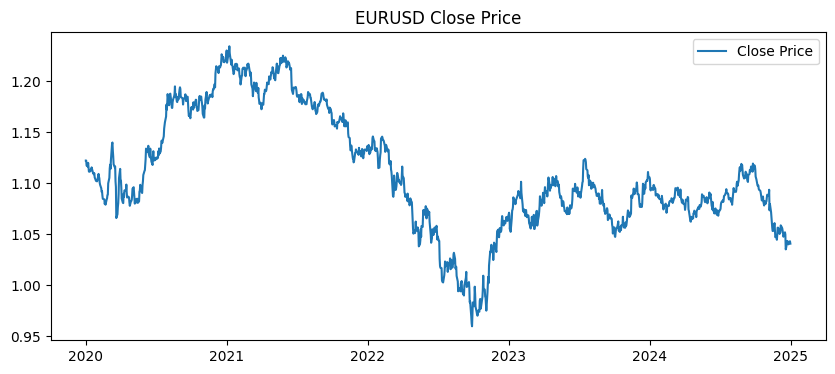


=== Step 4: Market Analysis ===
Loaded EURUSD_features.csv with shape (1305, 14)
Dropped 0 rows due to NaN in 'Close'
Loaded Gold.csv with shape (1258, 5)
Dropped 0 rows due to NaN in 'Close'

=== Market Analysis ===
Correlation between EURUSD and Gold: -0.1456

Granger causality test (max_lag=5):
Lag 1: p-value = 0.7605
Lag 2: p-value = 0.0000
Lag 3: p-value = 0.0000
Lag 4: p-value = 0.0000
Lag 5: p-value = 0.0000

Cointegration test: statistic=-1.6141, p-value=0.7149


=== Step 5: Modeling & Prediction ===
Loaded EURUSD_features.csv with shape (1305, 14)
Dropped 0 rows due to NaN in 'Close'
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step

=== Step 6: Backtesting Strategies ===
Trend-Following -> Sharpe: -0.4720, Max DD: 0.0901, CAGR: -2.9316%

=== Step 7: Risk Management ===

=== Step 8: Visualization & Reporting ===


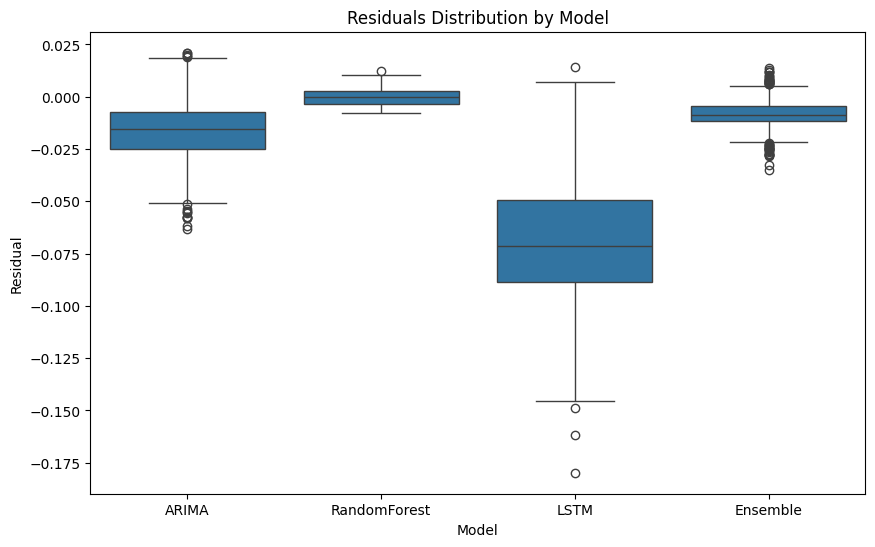

=== Strategy Report ===
Trend-Following Strategy Sharpe Ratio: -0.4720
Trend-Following Strategy Max Drawdown: 0.0901
Trend-Following Strategy CAGR: -3.0495%


In [2]:
!pip install yfinance xgboost catboost lightgbm shap plotly statsmodels tensorflow seaborn --quiet

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import coint, grangercausalitytests
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import warnings
warnings.filterwarnings("ignore")
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

def fetch_forex_data_from_yfinance(ticker: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end)
    if df.empty:
        raise ValueError(f"No data found for ticker: {ticker}")
    df.index = pd.to_datetime(df.index)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df

def fetch_commodity_data_from_yfinance(ticker: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end)
    if df.empty:
        raise ValueError(f"No data found for ticker: {ticker}")
    df.dropna(inplace=True)
    df.index = pd.to_datetime(df.index)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df

def save_data_to_csv(df: pd.DataFrame, filename: str):
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
    file_path = os.path.join(DATA_DIR, filename)
    df.to_csv(file_path)
    print(f"Saved {filename} to {DATA_DIR}/")

def load_data_from_csv(filename: str) -> pd.DataFrame:
    file_path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(file_path):
        print(f"File {filename} does not exist in {DATA_DIR}.")
        return pd.DataFrame()
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    print(f"Loaded {filename} with shape {df.shape}")
    df.columns = df.columns.str.strip()
    rename_map = {}
    for col in df.columns:
        if '_' in col and ('=X' in col or '=F' in col):
            main_col = col.split('_')[0]
            rename_map[col] = main_col
        else:
            rename_map[col] = col
    df.rename(columns=rename_map, inplace=True)
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    if 'Close' in df.columns:
        before = len(df)
        df.dropna(subset=['Close'], inplace=True)
        after = len(df)
        print(f"Dropped {before - after} rows due to NaN in 'Close'")
    return df

def main_data_fetching():
    print("=== Step 1: Fetching Data ===")
    try:
        eurusd_df = fetch_forex_data_from_yfinance("EURUSD=X", start="2020-01-01", end="2025-01-01")
        save_data_to_csv(eurusd_df, "EURUSD.csv")
    except Exception as e:
        print(f"Error fetching EUR/USD data: {e}")
    try:
        gold_df = fetch_commodity_data_from_yfinance("GC=F", start="2020-01-01", end="2025-01-01")
        save_data_to_csv(gold_df, "Gold.csv")
    except Exception as e:
        print(f"Error fetching Gold data: {e}")
    print("Data fetching completed and saved to CSV.")

def clean_and_preprocess_data(df: pd.DataFrame, fill_method: str = 'ffill', drop_duplicates: bool = True, remove_outliers_zscore: float = None, scale_method: str = None) -> pd.DataFrame:
    df = df.copy()
    if drop_duplicates:
        df = df[~df.index.duplicated(keep='first')]
    if fill_method == 'ffill':
        df.fillna(method='ffill', inplace=True)
    elif fill_method == 'bfill':
        df.fillna(method='bfill', inplace=True)
    elif fill_method == 'mean':
        df.fillna(df.mean(), inplace=True)
    if remove_outliers_zscore is not None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Volume', errors='ignore')
        if len(numeric_cols) > 0:
            z_scores = np.abs(zscore(df[numeric_cols]))
            z_scores = np.nan_to_num(z_scores, nan=np.inf, posinf=np.inf, neginf=np.inf)
            df = df[(z_scores < remove_outliers_zscore).all(axis=1)]
    if scale_method:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if scale_method == 'standard':
            scaler = StandardScaler()
            df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
        elif scale_method == 'minmax':
            scaler = MinMaxScaler()
            df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    window_length = 14
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=window_length - 1, adjust=False).mean()
    ema_down = down.ewm(com=window_length - 1, adjust=False).mean()
    rs = ema_up / ema_down
    df['RSI'] = 100 - (100 / (1 + rs))
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = rolling_mean + (rolling_std * 2)
    df['Bollinger_Lower'] = rolling_mean - (rolling_std * 2)
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window=20).std() * np.sqrt(20)
    return df

def main_data_preprocessing():
    print("\n=== Step 2: Preprocessing Data ===")
    eurusd_df = load_data_from_csv("EURUSD.csv")
    if eurusd_df.empty:
        return
    eurusd_cleaned = clean_and_preprocess_data(eurusd_df, fill_method='ffill', drop_duplicates=True, remove_outliers_zscore=3.0, scale_method=None)
    eurusd_features = add_technical_indicators(eurusd_cleaned)
    save_data_to_csv(eurusd_features, "EURUSD_features.csv")
    print("Preprocessing completed and features saved to CSV.")

def exploratory_data_analysis(df: pd.DataFrame, asset_name: str):
    print(f"\n=== Exploratory Data Analysis (EDA) for {asset_name} ===")
    plt.figure(figsize=(10, 4))
    plt.plot(df['Close'], label='Close Price')
    plt.title(f'{asset_name} Close Price')
    plt.legend()
    plt.show()
    corr = df.corr()
    fig = px.imshow(corr, text_auto=True, aspect="auto", title=f"{asset_name} Correlation Matrix")
    fig.show()

def main_eda():
    print("\n=== Step 3: Exploratory Data Analysis (EDA) ===")
    eurusd_df = load_data_from_csv("EURUSD_features.csv")
    if eurusd_df.empty:
        return
    exploratory_data_analysis(eurusd_df, "EURUSD")

def market_analysis(df1: pd.DataFrame, df2: pd.DataFrame, col_name: str = "Close", label1: str = "EURUSD", label2: str = "Gold"):
    print("\n=== Market Analysis ===")
    merged = pd.DataFrame()
    merged[label1] = df1[col_name].copy()
    merged[label2] = df2[col_name].copy()
    merged.dropna(inplace=True)
    if merged.empty:
        return
    corr_val = merged.corr().iloc[0, 1]
    print(f"Correlation between {label1} and {label2}: {corr_val:.4f}")
    max_lag = 5
    print(f"\nGranger causality test (max_lag={max_lag}):")
    try:
        granger_result = grangercausalitytests(merged[[label1, label2]], maxlag=max_lag, verbose=False)
        for lag, res in granger_result.items():
            p_value = res[0]['ssr_ftest'][1]
            print(f"Lag {lag}: p-value = {p_value:.4f}")
    except Exception as e:
        print(f"Granger causality test failed: {e}")
    try:
        coint_score, p_value, _ = coint(merged[label1], merged[label2])
        print(f"\nCointegration test: statistic={coint_score:.4f}, p-value={p_value:.4f}\n")
    except Exception as e:
        print(f"Cointegration test failed: {e}")

def main_market_analysis():
    print("\n=== Step 4: Market Analysis ===")
    eurusd_df = load_data_from_csv("EURUSD_features.csv")
    gold_df = load_data_from_csv("Gold.csv")
    if eurusd_df.empty or gold_df.empty:
        return
    market_analysis(eurusd_df, gold_df, col_name="Close", label1="EURUSD", label2="Gold")

def train_test_split_time_series(df, test_size=0.2):
    split_index = int(len(df) * (1 - test_size))
    train = df.iloc[:split_index].copy()
    test = df.iloc[split_index:].copy()
    return train, test

def evaluate_predictions(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

def arima_model(train, test, order=(1,1,1), col_name='Close'):
    model = ARIMA(train[col_name], order=order).fit()
    predictions = model.forecast(steps=len(test))
    return predictions

def sarima_model(train, test, order=(1,1,1), seasonal_order=(1,1,1,12), col_name='Close'):
    model = SARIMAX(train[col_name], order=order, seasonal_order=seasonal_order).fit()
    predictions = model.forecast(steps=len(test))
    return predictions

def var_model(train, test, cols=['Close']):
    model = VAR(train[cols].dropna())
    results = model.fit(maxlags=5, ic='aic')
    lag_order = results.k_ar
    forecast_input = train[cols].values[-lag_order:]
    forecast_vals = results.forecast(forecast_input, steps=len(test))
    return forecast_vals[:, 0]

def random_forest_model(train, test, features, target='Close'):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(train[features], train[target])
    preds = rf.predict(test[features])
    return preds

def xgb_model(train, test, features, target='Close'):
    xgb_model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    xgb_model.fit(train[features], train[target])
    preds = xgb_model.predict(test[features])
    return preds

def lgbm_model(train, test, features, target='Close'):
    lgb = LGBMRegressor(n_estimators=100, random_state=42)
    lgb.fit(train[features], train[target])
    preds = lgb.predict(test[features])
    return preds

def catboost_model(train, test, features, target='Close'):
    cat = CatBoostRegressor(verbose=0, random_state=42)
    cat.fit(train[features], train[target])
    preds = cat.predict(test[features])
    return preds

def prepare_sequence_data(df, features, target, window_size=10):
    data = df.copy()
    X_list, y_list = [], []
    for i in range(window_size, len(data)):
        X_list.append(data[features].iloc[i-window_size:i].values)
        y_list.append(data[target].iloc[i])
    X_arr = np.array(X_list)
    y_arr = np.array(y_list)
    return X_arr, y_arr

def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def deep_learning_model(train, test, features, target='Close', epochs=10, window_size=10):
    X_train, y_train = prepare_sequence_data(train, features, target, window_size)
    X_test, y_test = prepare_sequence_data(test, features, target, window_size)
    model = build_lstm((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)
    preds = model.predict(X_test).flatten()
    return preds, y_test

def ensemble_predictions(preds_list, weights=None):
    preds_arr = np.array(preds_list)
    if weights is None:
        weights = [1.0 / len(preds_list)] * len(preds_list)
    weighted_preds = np.tensordot(preds_arr, weights, axes=((0), (0)))
    return weighted_preds

def main_modeling():
    print("\n=== Step 5: Modeling & Prediction ===")
    df = load_data_from_csv("EURUSD_features.csv")
    if df.empty:
        return None, None, None, None, None
    features = ['MA_20', 'MA_50', 'RSI', 'MACD', 'Signal', 'Volatility']
    if not all(feature in df.columns for feature in features):
        return None, None, None, None, None
    df.dropna(inplace=True)
    train_df, test_df = train_test_split_time_series(df)
    try:
        arima_preds = arima_model(train_df, test_df, order=(2,1,2), col_name='Close')
    except Exception as e:
        arima_preds = None
    try:
        rf_preds = random_forest_model(train_df, test_df, features, target='Close')
    except Exception as e:
        rf_preds = None
    try:
        lstm_preds, lstm_true = deep_learning_model(train_df, test_df, features, target='Close', epochs=10, window_size=10)
        window_size = 10
        aligned_test_df = test_df.iloc[window_size:].copy()
    except Exception as e:
        lstm_preds, aligned_test_df = None, None
    if arima_preds is not None and rf_preds is not None:
        if aligned_test_df is not None:
            arima_preds_aligned = arima_preds[window_size:]
            rf_preds_aligned = rf_preds[window_size:]
            ensemble_preds = ensemble_predictions([arima_preds_aligned, rf_preds_aligned], weights=[0.5, 0.5])
        else:
            ensemble_preds = ensemble_predictions([arima_preds, rf_preds], weights=[0.5, 0.5])
    else:
        ensemble_preds = None
    if arima_preds is not None:
        if aligned_test_df is not None:
            arima_rmse, arima_mae, arima_r2 = evaluate_predictions(aligned_test_df['Close'], arima_preds_aligned)
        else:
            arima_rmse, arima_mae, arima_r2 = evaluate_predictions(test_df['Close'], arima_preds)
    if rf_preds is not None:
        if aligned_test_df is not None:
            rf_preds_aligned = rf_preds[window_size:]
            rf_rmse, rf_mae, rf_r2 = evaluate_predictions(aligned_test_df['Close'], rf_preds_aligned)
        else:
            rf_rmse, rf_mae, rf_r2 = evaluate_predictions(test_df['Close'], rf_preds)
    if lstm_preds is not None and lstm_true is not None:
        lstm_rmse, lstm_mae, lstm_r2 = evaluate_predictions(lstm_true, lstm_preds)
    if ensemble_preds is not None:
        if aligned_test_df is not None:
            ensemble_rmse, ensemble_mae, ensemble_r2 = evaluate_predictions(aligned_test_df['Close'], ensemble_preds)
        else:
            ensemble_rmse, ensemble_mae, ensemble_r2 = evaluate_predictions(test_df['Close'], ensemble_preds)
    if aligned_test_df is not None:
        final_test_df = aligned_test_df
    else:
        final_test_df = test_df
    return final_test_df, arima_preds_aligned if arima_preds is not None and aligned_test_df is not None else arima_preds, rf_preds_aligned if rf_preds is not None and aligned_test_df is not None else rf_preds, lstm_preds, ensemble_preds

def trend_following_strategy(df: pd.DataFrame, short_window=20, long_window=50):
    df = df.copy()
    df['Signal'] = 0.0
    df['Signal'] = np.where(df['MA_20'] > df['MA_50'], 1.0, -1.0)
    df['Position'] = df['Signal'].shift(1).fillna(0)
    return df

def mean_reversion_strategy(df: pd.DataFrame):
    df = df.copy()
    df['Signal'] = 0.0
    df['Signal'] = np.where(df['Close'] < df['Bollinger_Lower'], 1.0, df['Signal'])
    df['Signal'] = np.where(df['Close'] > df['Bollinger_Upper'], -1.0, df['Signal'])
    df['Position'] = df['Signal'].shift(1).fillna(0)
    return df

def ensemble_strategy(df: pd.DataFrame, preds_df: pd.DataFrame):
    df = df.copy()
    df['Signal'] = np.sign(preds_df.mean(axis=1))
    df['Position'] = df['Signal'].shift(1).fillna(0)
    return df

def backtest_strategy(df: pd.DataFrame, col_close='Close', position_col='Position', transaction_cost=0.0001):
    df = df.copy()
    df['Market_Return'] = df[col_close].pct_change().fillna(0)
    df['Strategy_Return'] = df[position_col] * df['Market_Return']
    df['Strategy_Return_After_Cost'] = df['Strategy_Return'] - transaction_cost * abs(df[position_col].diff().fillna(0))
    df['Strategy_Return_After_Cost'].fillna(0, inplace=True)
    df['Cumulative_Market'] = (1 + df['Market_Return']).cumprod()
    df['Cumulative_Strategy'] = (1 + df['Strategy_Return_After_Cost']).cumprod()
    df['Cumulative_Strategy'].fillna(method='ffill', inplace=True)
    df['Cumulative_Strategy'].fillna(1, inplace=True)
    annual_factor = 252
    strategy_mean = df['Strategy_Return_After_Cost'].mean()
    strategy_std = df['Strategy_Return_After_Cost'].std()
    if strategy_std != 0:
        sharpe_ratio = (strategy_mean / strategy_std) * np.sqrt(annual_factor)
    else:
        sharpe_ratio = 0.0
    max_drawdown = (df['Cumulative_Strategy'].cummax() - df['Cumulative_Strategy']).max()
    if len(df) > 0 and df['Cumulative_Strategy'].iloc[0] > 0:
        cagr = (df['Cumulative_Strategy'].iloc[-1] / df['Cumulative_Strategy'].iloc[0])**(1/(len(df)/annual_factor)) - 1
    else:
        cagr = np.nan
    return df, sharpe_ratio, max_drawdown, cagr

def main_backtest(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds):
    print("\n=== Step 6: Backtesting Strategies ===")
    strategy_df = trend_following_strategy(test_df)
    results, sharpe, mdd, cagr = backtest_strategy(strategy_df)
    if sharpe is not None:
        print(f"Trend-Following -> Sharpe: {sharpe:.4f}, Max DD: {mdd:.4f}, CAGR: {cagr*100:.4f}%")
    return results

def visualization_and_reporting(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds, backtest_results):
    print("\n=== Step 8: Visualization & Reporting ===")
    predictions_df = pd.DataFrame({'Date': test_df.index, 'Actual_Close': test_df['Close']})
    if arima_preds is not None:
        predictions_df['ARIMA_Predicted'] = arima_preds
    if rf_preds is not None:
        predictions_df['RandomForest_Predicted'] = rf_preds
    if lstm_preds is not None:
        predictions_df['LSTM_Predicted'] = lstm_preds
    if ensemble_preds is not None:
        predictions_df['Ensemble_Predicted'] = ensemble_preds
    min_length = len(test_df)
    for pred in ['ARIMA_Predicted', 'RandomForest_Predicted', 'LSTM_Predicted', 'Ensemble_Predicted']:
        if pred in predictions_df.columns:
            min_length = min(min_length, len(predictions_df[pred]))
    if min_length < len(test_df):
        predictions_df = predictions_df.iloc[:min_length]
    predictions_df.set_index('Date', inplace=True)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Actual_Close'], mode='lines', name='Actual'))
    if 'ARIMA_Predicted' in predictions_df.columns:
        fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['ARIMA_Predicted'], mode='lines', name='ARIMA'))
    if 'RandomForest_Predicted' in predictions_df.columns:
        fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['RandomForest_Predicted'], mode='lines', name='Random Forest'))
    if 'LSTM_Predicted' in predictions_df.columns:
        fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['LSTM_Predicted'], mode='lines', name='LSTM'))
    if 'Ensemble_Predicted' in predictions_df.columns:
        fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Ensemble_Predicted'], mode='lines', name='Ensemble'))
    fig.update_layout(title='Actual vs Predicted EUR/USD Close Prices', xaxis_title='Date', yaxis_title='EUR/USD Price', hovermode='x unified')
    fig.show()
    if 'ARIMA_Predicted' in predictions_df.columns:
        predictions_df['ARIMA_Residual'] = predictions_df['Actual_Close'] - predictions_df['ARIMA_Predicted']
    if 'RandomForest_Predicted' in predictions_df.columns:
        predictions_df['RandomForest_Residual'] = predictions_df['Actual_Close'] - predictions_df['RandomForest_Predicted']
    if 'LSTM_Predicted' in predictions_df.columns:
        predictions_df['LSTM_Residual'] = predictions_df['Actual_Close'] - predictions_df['LSTM_Predicted']
    if 'Ensemble_Predicted' in predictions_df.columns:
        predictions_df['Ensemble_Residual'] = predictions_df['Actual_Close'] - predictions_df['Ensemble_Predicted']
    residual_models = ['ARIMA_Residual', 'RandomForest_Residual', 'LSTM_Residual', 'Ensemble_Residual']
    for residual in residual_models:
        if residual in predictions_df.columns:
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df[residual], mode='lines', name=residual))
            fig.update_layout(title=f'Residuals Over Time - {residual.split("_")[0]} Model', xaxis_title='Date', yaxis_title='Residual EUR/USD Price', hovermode='x unified')
            fig.show()
    if 'Cumulative_Strategy' in backtest_results.columns and 'Cumulative_Market' in backtest_results.columns:
        if not backtest_results['Cumulative_Strategy'].isna().any() and not backtest_results['Cumulative_Market'].isna().any():
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=backtest_results.index, y=backtest_results['Cumulative_Market'], mode='lines', name='Market Cumulative Returns'))
            fig.add_trace(go.Scatter(x=backtest_results.index, y=backtest_results['Cumulative_Strategy'], mode='lines', name='Strategy Cumulative Returns'))
            fig.update_layout(title='Strategy vs Market Cumulative Returns', xaxis_title='Date', yaxis_title='Cumulative Returns', hovermode='x unified')
            fig.show()
    model_preds = ['ARIMA_Predicted', 'RandomForest_Predicted', 'LSTM_Predicted', 'Ensemble_Predicted']
    existing_preds = [pred for pred in model_preds if pred in predictions_df.columns]
    if len(existing_preds) >= 2:
        corr_matrix = predictions_df[existing_preds].corr()
        fig = px.imshow(corr_matrix, text_auto=True, aspect="auto", title="Correlation Matrix of Model Predictions", color_continuous_scale='RdBu_r', zmin=-1, zmax=1)
        fig.show()
    models = ['ARIMA', 'RandomForest', 'LSTM', 'Ensemble']
    for model in models:
        pred_col = f'{model}_Predicted'
        if pred_col in predictions_df.columns:
            fig = px.scatter(predictions_df, x='Actual_Close', y=pred_col, trendline="ols", title=f'Actual vs Predicted Close Prices - {model}', labels={'Actual_Close': 'Actual Close', pred_col: 'Predicted Close'})
            fig.show()
    residuals = []
    residual_labels = []
    for residual in residual_models:
        if residual in predictions_df.columns:
            residuals.append(predictions_df[residual])
            residual_labels.append(residual.split('_')[0])
    if residuals:
        residuals_df = pd.DataFrame({'Residual': pd.concat(residuals), 'Model': np.repeat(residual_labels, [len(r) for r in residuals])})
        plt.figure(figsize=(10,6))
        sns.boxplot(x='Model', y='Residual', data=residuals_df)
        plt.title('Residuals Distribution by Model')
        plt.show()
    if residuals:
        fig = go.Figure()
        for residual, label in zip(residuals, residual_labels):
            fig.add_trace(go.Histogram(x=residual, name=f'{label} Residual', opacity=0.75))
        fig.update_layout(barmode='overlay', title='Distribution of Residuals by Model', xaxis_title='Residual EUR/USD Price', yaxis_title='Count', hovermode='x unified')
        fig.show()
    print("=== Strategy Report ===")
    if 'Strategy_Return_After_Cost' in backtest_results.columns:
        sharpe_ratio = (backtest_results['Strategy_Return_After_Cost'].mean() / backtest_results['Strategy_Return_After_Cost'].std()) * np.sqrt(252)
        cumulative = backtest_results['Cumulative_Strategy']
        rolling_max = cumulative.cummax()
        drawdown = rolling_max - cumulative
        max_drawdown = drawdown.max()
        start_date = backtest_results.index[0]
        end_date = backtest_results.index[-1]
        num_years = (end_date - start_date).days / 365.25
        if num_years > 0 and cumulative.iloc[0] > 0:
            cagr = (cumulative.iloc[-1] / cumulative.iloc[0])**(1/num_years) - 1
        else:
            cagr = np.nan
        print(f"Trend-Following Strategy Sharpe Ratio: {sharpe_ratio:.4f}")
        print(f"Trend-Following Strategy Max Drawdown: {max_drawdown:.4f}")
        if not np.isnan(cagr):
            print(f"Trend-Following Strategy CAGR: {cagr*100:.4f}%")
        else:
            print(f"Trend-Following Strategy CAGR: nan%")

def main():
    main_data_fetching()
    main_data_preprocessing()
    main_eda()
    main_market_analysis()
    test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds = main_modeling()
    if test_df is not None:
        backtest_results = main_backtest(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds)
    else:
        backtest_results = None
    print("\n=== Step 7: Risk Management ===")
    if backtest_results is not None:
        visualization_and_reporting(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds, backtest_results)

main()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

=== Step 1: Fetching Data ===
Saved EURUSD.csv to data/
Saved Gold.csv to data/
Data fetching completed and saved to CSV.

=== Step 2: Preprocessing Data ===
Loaded EURUSD.csv with shape (1305, 5)
Dropped 0 rows due to NaN in 'Close'


Saved EURUSD_features.csv to data/
Preprocessing completed and features saved to CSV.

=== Step 3: Exploratory Data Analysis (EDA) ===
Loaded EURUSD_features.csv with shape (1305, 14)
Dropped 0 rows due to NaN in 'Close'

=== Exploratory Data Analysis (EDA) for EURUSD ===


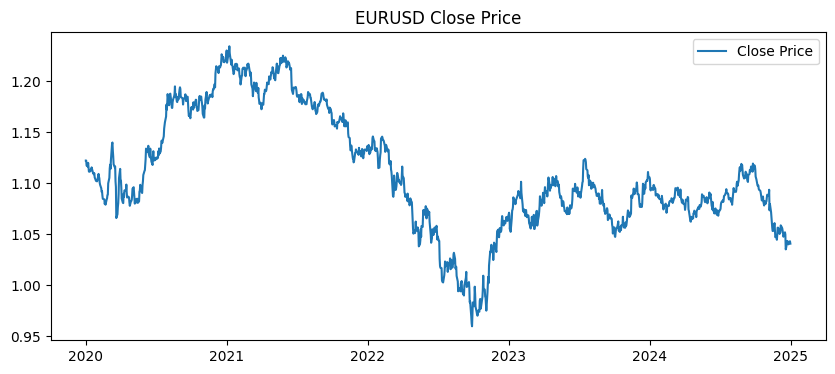


=== Step 4: Market Analysis ===
Loaded EURUSD_features.csv with shape (1305, 14)
Dropped 0 rows due to NaN in 'Close'
Loaded Gold.csv with shape (1258, 5)
Dropped 0 rows due to NaN in 'Close'

=== Market Analysis ===
Correlation between EURUSD and Gold: -0.1456

Granger causality test (max_lag=5):
Lag 1: p-value = 0.7605
Lag 2: p-value = 0.0000
Lag 3: p-value = 0.0000
Lag 4: p-value = 0.0000
Lag 5: p-value = 0.0000

Cointegration test: statistic=-1.6141, p-value=0.7149


=== Step 5: Modeling & Prediction ===
Loaded EURUSD_features.csv with shape (1305, 14)
Dropped 0 rows due to NaN in 'Close'
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step

=== Step 6: Backtesting Strategies ===
Trend-Following -> Sharpe: -0.4730, Max DD: 0.0901, CAGR: -0.0293

=== Step 7: Risk Management ===

=== Step 8: Visualization & Reporting ===


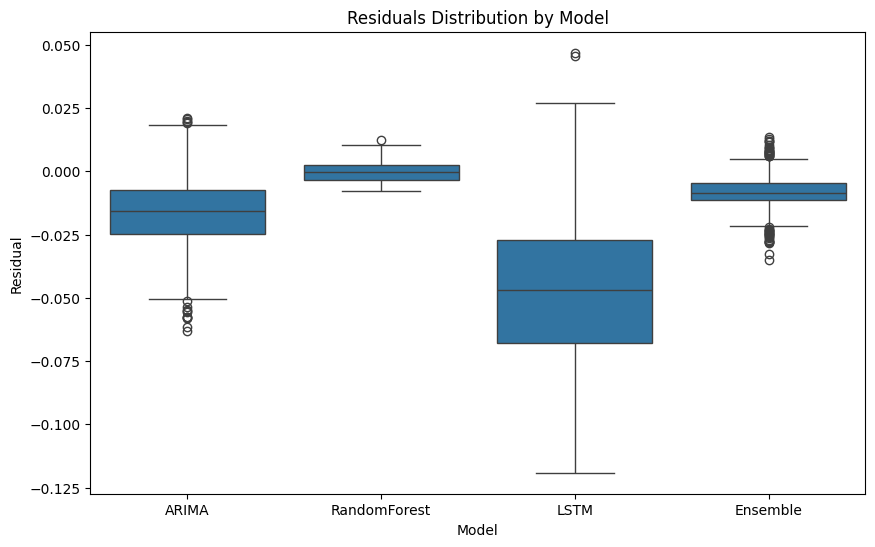

=== Strategy Report ===
Trend-Following Strategy Sharpe Ratio: -0.4730
Trend-Following Strategy Max Drawdown: 0.0901
Trend-Following Strategy CAGR: nan%


In [9]:
!pip install catboost
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import coint, grangercausalitytests
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import warnings
warnings.filterwarnings("ignore")
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

def fetch_forex_data_from_yfinance(ticker: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end)
    if df.empty:
        raise ValueError(f"No data found for ticker: {ticker}")
    df.index = pd.to_datetime(df.index)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df

def fetch_commodity_data_from_yfinance(ticker: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end)
    if df.empty:
        raise ValueError(f"No data found for ticker: {ticker}")
    df.dropna(inplace=True)
    df.index = pd.to_datetime(df.index)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df

def save_data_to_csv(df: pd.DataFrame, filename: str):
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
    file_path = os.path.join(DATA_DIR, filename)
    df.to_csv(file_path)
    print(f"Saved {filename} to {DATA_DIR}/")

def load_data_from_csv(filename: str) -> pd.DataFrame:
    file_path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(file_path):
        print(f"File {filename} does not exist in {DATA_DIR}.")
        return pd.DataFrame()
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    print(f"Loaded {filename} with shape {df.shape}")
    df.columns = df.columns.str.strip()
    rename_map = {}
    for col in df.columns:
        if '_' in col and ('=X' in col or '=F' in col):
            main_col = col.split('_')[0]
            rename_map[col] = main_col
        else:
            rename_map[col] = col
    df.rename(columns=rename_map, inplace=True)
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    if 'Close' in df.columns:
        before = len(df)
        df.dropna(subset=['Close'], inplace=True)
        after = len(df)
        print(f"Dropped {before - after} rows due to NaN in 'Close'")
    return df

def main_data_fetching():
    print("=== Step 1: Fetching Data ===")
    try:
        eurusd_df = fetch_forex_data_from_yfinance("EURUSD=X", start="2020-01-01", end="2025-01-01")
        save_data_to_csv(eurusd_df, "EURUSD.csv")
    except Exception as e:
        print(f"Error fetching EUR/USD data: {e}")
    try:
        gold_df = fetch_commodity_data_from_yfinance("GC=F", start="2020-01-01", end="2025-01-01")
        save_data_to_csv(gold_df, "Gold.csv")
    except Exception as e:
        print(f"Error fetching Gold data: {e}")
    print("Data fetching completed and saved to CSV.")

def clean_and_preprocess_data(df: pd.DataFrame, fill_method: str = 'ffill', drop_duplicates: bool = True, remove_outliers_zscore: float = None, scale_method: str = None) -> pd.DataFrame:
    df = df.copy()
    if drop_duplicates:
        df = df[~df.index.duplicated(keep='first')]
    if fill_method == 'ffill':
        df.fillna(method='ffill', inplace=True)
    elif fill_method == 'bfill':
        df.fillna(method='bfill', inplace=True)
    elif fill_method == 'mean':
        df.fillna(df.mean(), inplace=True)
    if remove_outliers_zscore is not None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Volume', errors='ignore')
        if len(numeric_cols) > 0:
            z_scores = np.abs(zscore(df[numeric_cols]))
            z_scores = np.nan_to_num(z_scores, nan=np.inf, posinf=np.inf, neginf=np.inf)
            df = df[(z_scores < remove_outliers_zscore).all(axis=1)]
    if scale_method:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if scale_method == 'standard':
            scaler = StandardScaler()
            df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
        elif scale_method == 'minmax':
            scaler = MinMaxScaler()
            df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    window_length = 14
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=window_length - 1, adjust=False).mean()
    ema_down = down.ewm(com=window_length - 1, adjust=False).mean()
    rs = ema_up / ema_down
    df['RSI'] = 100 - (100 / (1 + rs))
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = rolling_mean + (rolling_std * 2)
    df['Bollinger_Lower'] = rolling_mean - (rolling_std * 2)
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window=20).std() * np.sqrt(20)
    return df

def main_data_preprocessing():
    print("\n=== Step 2: Preprocessing Data ===")
    eurusd_df = load_data_from_csv("EURUSD.csv")
    if eurusd_df.empty:
        return
    eurusd_cleaned = clean_and_preprocess_data(eurusd_df, fill_method='ffill', drop_duplicates=True, remove_outliers_zscore=3.0, scale_method=None)
    eurusd_features = add_technical_indicators(eurusd_cleaned)
    save_data_to_csv(eurusd_features, "EURUSD_features.csv")
    print("Preprocessing completed and features saved to CSV.")

def exploratory_data_analysis(df: pd.DataFrame, asset_name: str):
    print(f"\n=== Exploratory Data Analysis (EDA) for {asset_name} ===")
    plt.figure(figsize=(10, 4))
    plt.plot(df['Close'], label='Close Price')
    plt.title(f'{asset_name} Close Price')
    plt.legend()
    plt.show()
    corr = df.corr()
    fig = px.imshow(corr, text_auto=True, aspect="auto", title=f"{asset_name} Correlation Matrix")
    fig.show()

def main_eda():
    print("\n=== Step 3: Exploratory Data Analysis (EDA) ===")
    eurusd_df = load_data_from_csv("EURUSD_features.csv")
    if eurusd_df.empty:
        return
    exploratory_data_analysis(eurusd_df, "EURUSD")

def market_analysis(df1: pd.DataFrame, df2: pd.DataFrame, col_name: str = "Close", label1: str = "EURUSD", label2: str = "Gold"):
    print("\n=== Market Analysis ===")
    merged = pd.DataFrame()
    merged[label1] = df1[col_name].copy()
    merged[label2] = df2[col_name].copy()
    merged.dropna(inplace=True)
    if merged.empty:
        return
    corr_val = merged.corr().iloc[0, 1]
    print(f"Correlation between {label1} and {label2}: {corr_val:.4f}")
    max_lag = 5
    print(f"\nGranger causality test (max_lag={max_lag}):")
    try:
        granger_result = grangercausalitytests(merged[[label1, label2]], maxlag=max_lag, verbose=False)
        for lag, res in granger_result.items():
            p_value = res[0]['ssr_ftest'][1]
            print(f"Lag {lag}: p-value = {p_value:.4f}")
    except Exception as e:
        print(f"Granger causality test failed: {e}")
    try:
        coint_score, p_value, _ = coint(merged[label1], merged[label2])
        print(f"\nCointegration test: statistic={coint_score:.4f}, p-value={p_value:.4f}\n")
    except Exception as e:
        print(f"Cointegration test failed: {e}")

def main_market_analysis():
    print("\n=== Step 4: Market Analysis ===")
    eurusd_df = load_data_from_csv("EURUSD_features.csv")
    gold_df = load_data_from_csv("Gold.csv")
    if eurusd_df.empty or gold_df.empty:
        return
    market_analysis(eurusd_df, gold_df, col_name="Close", label1="EURUSD", label2="Gold")

def train_test_split_time_series(df, test_size=0.2):
    split_index = int(len(df) * (1 - test_size))
    train = df.iloc[:split_index].copy()
    test = df.iloc[split_index:].copy()
    return train, test

def evaluate_predictions(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

def arima_model(train, test, order=(1,1,1), col_name='Close'):
    model = ARIMA(train[col_name], order=order).fit()
    predictions = model.forecast(steps=len(test))
    return predictions

def sarima_model(train, test, order=(1,1,1), seasonal_order=(1,1,1,12), col_name='Close'):
    model = SARIMAX(train[col_name], order=order, seasonal_order=seasonal_order).fit()
    predictions = model.forecast(steps=len(test))
    return predictions

def var_model(train, test, cols=['Close']):
    model = VAR(train[cols].dropna())
    results = model.fit(maxlags=5, ic='aic')
    lag_order = results.k_ar
    forecast_input = train[cols].values[-lag_order:]
    forecast_vals = results.forecast(forecast_input, steps=len(test))
    return forecast_vals[:, 0]

def random_forest_model(train, test, features, target='Close'):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(train[features], train[target])
    preds = rf.predict(test[features])
    return preds

def xgb_model(train, test, features, target='Close'):
    xgb_model = XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(train[features], train[target])
    preds = xgb_model.predict(test[features])
    return preds

def lgbm_model(train, test, features, target='Close'):
    lgb = LGBMRegressor(n_estimators=100, random_state=42)
    lgb.fit(train[features], train[target])
    preds = lgb.predict(test[features])
    return preds

def catboost_model(train, test, features, target='Close'):
    cat = CatBoostRegressor(verbose=0, random_state=42)
    cat.fit(train[features], train[target])
    preds = cat.predict(test[features])
    return preds

def prepare_sequence_data(df, features, target, window_size=10):
    data = df.copy()
    X_list, y_list = [], []
    for i in range(window_size, len(data)):
        X_list.append(data[features].iloc[i-window_size:i].values)
        y_list.append(data[target].iloc[i])
    X_arr = np.array(X_list)
    y_arr = np.array(y_list)
    return X_arr, y_arr

def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def deep_learning_model(train, test, features, target='Close', epochs=10, window_size=10):
    X_train, y_train = prepare_sequence_data(train, features, target, window_size)
    X_test, y_test = prepare_sequence_data(test, features, target, window_size)
    model = build_lstm((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)
    preds = model.predict(X_test).flatten()
    return preds, y_test

def ensemble_predictions(preds_list, weights=None):
    preds_arr = np.array(preds_list)
    if weights is None:
        weights = [1.0 / len(preds_list)] * len(preds_list)
    weighted_preds = np.tensordot(preds_arr, weights, axes=((0), (0)))
    return weighted_preds

def main_modeling():
    print("\n=== Step 5: Modeling & Prediction ===")
    df = load_data_from_csv("EURUSD_features.csv")
    if df.empty:
        return None, None, None, None, None
    features = ['MA_20', 'MA_50', 'RSI', 'MACD', 'Signal', 'Volatility']
    if not all(feature in df.columns for feature in features):
        return None, None, None, None, None
    df.dropna(inplace=True)
    train_df, test_df = train_test_split_time_series(df)
    try:
        arima_preds = arima_model(train_df, test_df, order=(2,1,2), col_name='Close')
    except Exception as e:
        arima_preds = None
    try:
        rf_preds = random_forest_model(train_df, test_df, features, target='Close')
    except Exception as e:
        rf_preds = None
    try:
        lstm_preds, lstm_true = deep_learning_model(train_df, test_df, features, target='Close', epochs=10, window_size=10)
        window_size = 10
        aligned_test_df = test_df.iloc[window_size:].copy()
    except Exception as e:
        lstm_preds, aligned_test_df = None, None
    if arima_preds is not None and rf_preds is not None:
        if aligned_test_df is not None:
            arima_preds_aligned = arima_preds[window_size:]
            rf_preds_aligned = rf_preds[window_size:]
            ensemble_preds = ensemble_predictions([arima_preds_aligned, rf_preds_aligned], weights=[0.5, 0.5])
        else:
            ensemble_preds = ensemble_predictions([arima_preds, rf_preds], weights=[0.5, 0.5])
    else:
        ensemble_preds = None
    if arima_preds is not None:
        if aligned_test_df is not None:
            arima_rmse, arima_mae, arima_r2 = evaluate_predictions(aligned_test_df['Close'], arima_preds_aligned)
        else:
            arima_rmse, arima_mae, arima_r2 = evaluate_predictions(test_df['Close'], arima_preds)
    if rf_preds is not None:
        if aligned_test_df is not None:
            rf_preds_aligned = rf_preds[window_size:]
            rf_rmse, rf_mae, rf_r2 = evaluate_predictions(aligned_test_df['Close'], rf_preds_aligned)
        else:
            rf_rmse, rf_mae, rf_r2 = evaluate_predictions(test_df['Close'], rf_preds)
    if lstm_preds is not None and lstm_true is not None:
        lstm_rmse, lstm_mae, lstm_r2 = evaluate_predictions(lstm_true, lstm_preds)
    if ensemble_preds is not None:
        if aligned_test_df is not None:
            ensemble_rmse, ensemble_mae, ensemble_r2 = evaluate_predictions(aligned_test_df['Close'], ensemble_preds)
        else:
            ensemble_rmse, ensemble_mae, ensemble_r2 = evaluate_predictions(test_df['Close'], ensemble_preds)
    if aligned_test_df is not None:
        final_test_df = aligned_test_df
    else:
        final_test_df = test_df
    return final_test_df, arima_preds_aligned if arima_preds is not None and aligned_test_df is not None else arima_preds, rf_preds_aligned if rf_preds is not None and aligned_test_df is not None else rf_preds, lstm_preds, ensemble_preds

def trend_following_strategy(df: pd.DataFrame, short_window=20, long_window=50):
    df = df.copy()
    df['Signal'] = 0.0
    df['Signal'] = np.where(df['MA_20'] > df['MA_50'], 1.0, -1.0)
    df['Position'] = df['Signal'].shift(1).fillna(0)
    return df

def mean_reversion_strategy(df: pd.DataFrame):
    df = df.copy()
    df['Signal'] = 0.0
    df['Signal'] = np.where(df['Close'] < df['Bollinger_Lower'], 1.0, df['Signal'])
    df['Signal'] = np.where(df['Close'] > df['Bollinger_Upper'], -1.0, df['Signal'])
    df['Position'] = df['Signal'].shift(1).fillna(0)
    return df

def ensemble_strategy(df: pd.DataFrame, preds_df: pd.DataFrame):
    df = df.copy()
    df['Signal'] = np.sign(preds_df.mean(axis=1))
    df['Position'] = df['Signal'].shift(1).fillna(0)
    return df

def backtest_strategy(df: pd.DataFrame, col_close='Close', position_col='Position', transaction_cost=0.0001):
    df = df.copy()
    df['Market_Return'] = df[col_close].pct_change()
    df['Strategy_Return'] = df[position_col] * df['Market_Return']
    df['Strategy_Return_After_Cost'] = df['Strategy_Return'] - transaction_cost * abs(df[position_col].diff().fillna(0))
    df['Cumulative_Market'] = (1 + df['Market_Return']).cumprod()
    df['Cumulative_Strategy'] = (1 + df['Strategy_Return_After_Cost']).cumprod()
    annual_factor = 252
    sharpe_ratio = (df['Strategy_Return_After_Cost'].mean() / df['Strategy_Return_After_Cost'].std()) * np.sqrt(annual_factor)
    max_drawdown = (df['Cumulative_Strategy'].cummax() - df['Cumulative_Strategy']).max()
    cagr = (df['Cumulative_Strategy'].iloc[-1])**(1/(len(df)/annual_factor)) - 1
    return df, sharpe_ratio, max_drawdown, cagr

def main_backtest(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds):
    print("\n=== Step 6: Backtesting Strategies ===")
    strategy_df = trend_following_strategy(test_df)
    results, sharpe, mdd, cagr = backtest_strategy(strategy_df)
    if sharpe is not None:
        print(f"Trend-Following -> Sharpe: {sharpe:.4f}, Max DD: {mdd:.4f}, CAGR: {cagr:.4f}")
    return results

def visualization_and_reporting(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds, backtest_results):
    print("\n=== Step 8: Visualization & Reporting ===")
    predictions_df = pd.DataFrame({'Date': test_df.index, 'Actual_Close': test_df['Close']})
    if arima_preds is not None:
        predictions_df['ARIMA_Predicted'] = arima_preds
    if rf_preds is not None:
        predictions_df['RandomForest_Predicted'] = rf_preds
    if lstm_preds is not None:
        predictions_df['LSTM_Predicted'] = lstm_preds
    if ensemble_preds is not None:
        predictions_df['Ensemble_Predicted'] = ensemble_preds
    min_length = len(test_df)
    for pred in ['ARIMA_Predicted', 'RandomForest_Predicted', 'LSTM_Predicted', 'Ensemble_Predicted']:
        if pred in predictions_df.columns:
            min_length = min(min_length, len(predictions_df[pred]))
    if min_length < len(test_df):
        predictions_df = predictions_df.iloc[:min_length]
    predictions_df.set_index('Date', inplace=True)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Actual_Close'], mode='lines', name='Actual'))
    if 'ARIMA_Predicted' in predictions_df.columns:
        fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['ARIMA_Predicted'], mode='lines', name='ARIMA'))
    if 'RandomForest_Predicted' in predictions_df.columns:
        fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['RandomForest_Predicted'], mode='lines', name='Random Forest'))
    if 'LSTM_Predicted' in predictions_df.columns:
        fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['LSTM_Predicted'], mode='lines', name='LSTM'))
    if 'Ensemble_Predicted' in predictions_df.columns:
        fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Ensemble_Predicted'], mode='lines', name='Ensemble'))
    fig.update_layout(title='Actual vs Predicted EUR/USD Close Prices', xaxis_title='Date', yaxis_title='EUR/USD Price', hovermode='x unified')
    fig.show()
    if 'ARIMA_Predicted' in predictions_df.columns:
        predictions_df['ARIMA_Residual'] = predictions_df['Actual_Close'] - predictions_df['ARIMA_Predicted']
    if 'RandomForest_Predicted' in predictions_df.columns:
        predictions_df['RandomForest_Residual'] = predictions_df['Actual_Close'] - predictions_df['RandomForest_Predicted']
    if 'LSTM_Predicted' in predictions_df.columns:
        predictions_df['LSTM_Residual'] = predictions_df['Actual_Close'] - predictions_df['LSTM_Predicted']
    if 'Ensemble_Predicted' in predictions_df.columns:
        predictions_df['Ensemble_Residual'] = predictions_df['Actual_Close'] - predictions_df['Ensemble_Predicted']
    residual_models = ['ARIMA_Residual', 'RandomForest_Residual', 'LSTM_Residual', 'Ensemble_Residual']
    for residual in residual_models:
        if residual in predictions_df.columns:
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df[residual], mode='lines', name=residual))
            fig.update_layout(title=f'Residuals Over Time - {residual.split("_")[0]} Model', xaxis_title='Date', yaxis_title='Residual EUR/USD Price', hovermode='x unified')
            fig.show()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=backtest_results.index, y=backtest_results['Cumulative_Market'], mode='lines', name='Market Cumulative Returns'))
    fig.add_trace(go.Scatter(x=backtest_results.index, y=backtest_results['Cumulative_Strategy'], mode='lines', name='Strategy Cumulative Returns'))
    fig.update_layout(title='Strategy vs Market Cumulative Returns', xaxis_title='Date', yaxis_title='Cumulative Returns', hovermode='x unified')
    fig.show()
    model_preds = ['ARIMA_Predicted', 'RandomForest_Predicted', 'LSTM_Predicted', 'Ensemble_Predicted']
    existing_preds = [pred for pred in model_preds if pred in predictions_df.columns]
    if len(existing_preds) >= 2:
        corr_matrix = predictions_df[existing_preds].corr()
        fig = px.imshow(corr_matrix, text_auto=True, aspect="auto", title="Correlation Matrix of Model Predictions", color_continuous_scale='RdBu_r', zmin=-1, zmax=1)
        fig.show()
    models = ['ARIMA', 'RandomForest', 'LSTM', 'Ensemble']
    for model in models:
        pred_col = f'{model}_Predicted'
        if pred_col in predictions_df.columns:
            fig = px.scatter(predictions_df, x='Actual_Close', y=pred_col, trendline="ols", title=f'Actual vs Predicted Close Prices - {model}', labels={'Actual_Close': 'Actual Close', pred_col: 'Predicted Close'})
            fig.show()
    residuals = []
    residual_labels = []
    for residual in residual_models:
        if residual in predictions_df.columns:
            residuals.append(predictions_df[residual])
            residual_labels.append(residual.split('_')[0])
    if residuals:
        residuals_df = pd.DataFrame({'Residual': pd.concat(residuals), 'Model': np.repeat(residual_labels, [len(r) for r in residuals])})
        plt.figure(figsize=(10,6))
        sns.boxplot(x='Model', y='Residual', data=residuals_df)
        plt.title('Residuals Distribution by Model')
        plt.show()
    if residuals:
        fig = go.Figure()
        for residual, label in zip(residuals, residual_labels):
            fig.add_trace(go.Histogram(x=residual, name=f'{label} Residual', opacity=0.75))
        fig.update_layout(barmode='overlay', title='Distribution of Residuals by Model', xaxis_title='Residual EUR/USD Price', yaxis_title='Count', hovermode='x unified')
        fig.show()
    print("=== Strategy Report ===")
    if 'Strategy_Return_After_Cost' in backtest_results.columns:
        sharpe_ratio = (backtest_results['Strategy_Return_After_Cost'].mean() / backtest_results['Strategy_Return_After_Cost'].std()) * np.sqrt(252)
        cumulative = backtest_results['Cumulative_Strategy']
        rolling_max = cumulative.cummax()
        drawdown = rolling_max - cumulative
        max_drawdown = drawdown.max()
        start_date = backtest_results.index[0]
        end_date = backtest_results.index[-1]
        num_years = (end_date - start_date).days / 365.25
        cagr = (cumulative.iloc[-1] / cumulative.iloc[0])**(1/num_years) - 1
        print(f"Trend-Following Strategy Sharpe Ratio: {sharpe_ratio:.4f}")
        print(f"Trend-Following Strategy Max Drawdown: {max_drawdown:.4f}")
        print(f"Trend-Following Strategy CAGR: {cagr*100:.2f}%")

def main():
    main_data_fetching()
    main_data_preprocessing()
    main_eda()
    main_market_analysis()
    test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds = main_modeling()
    if test_df is not None:
        backtest_results = main_backtest(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds)
    else:
        backtest_results = None
    print("\n=== Step 7: Risk Management ===")
    if backtest_results is not None:
        visualization_and_reporting(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds, backtest_results)

main()

In [11]:
main_data_fetching()

[*********************100%***********************]  1 of 1 completed

=== Step 1: Fetching Data ===
Saved EURUSD.csv to data/



[*********************100%***********************]  1 of 1 completed

Saved Gold.csv to data/
Data fetching completed and saved to CSV.


In [10]:
main_data_preprocessing()


=== Step 2: Preprocessing Data ===
Loaded EURUSD.csv with shape (1305, 5)
Dropped 0 rows due to NaN in 'Close'
Saved EURUSD_features.csv to data/
Preprocessing completed and features saved to CSV.



=== Step 3: Exploratory Data Analysis (EDA) ===
Loaded EURUSD_features.csv with shape (1305, 14)
Dropped 0 rows due to NaN in 'Close'

=== Exploratory Data Analysis (EDA) for EURUSD ===


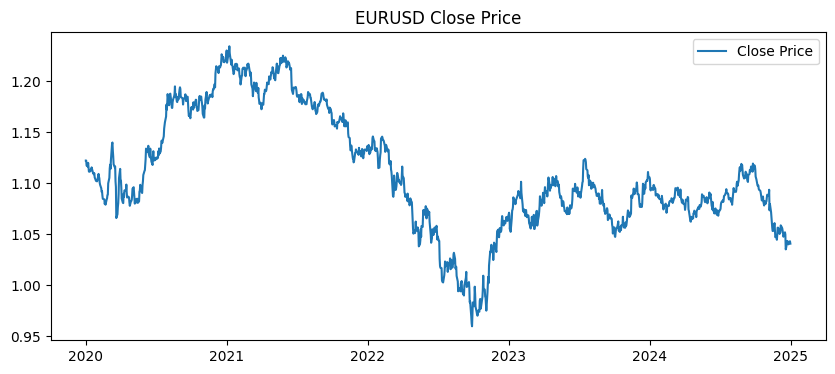

In [12]:
main_eda()

In [13]:
main_market_analysis()


=== Step 4: Market Analysis ===
Loaded EURUSD_features.csv with shape (1305, 14)
Dropped 0 rows due to NaN in 'Close'
Loaded Gold.csv with shape (1258, 5)
Dropped 0 rows due to NaN in 'Close'

=== Market Analysis ===
Correlation between EURUSD and Gold: -0.1456

Granger causality test (max_lag=5):
Lag 1: p-value = 0.7605
Lag 2: p-value = 0.0000
Lag 3: p-value = 0.0000
Lag 4: p-value = 0.0000
Lag 5: p-value = 0.0000

Cointegration test: statistic=-1.6141, p-value=0.7149



In [14]:
test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds = main_modeling()


=== Step 5: Modeling & Prediction ===
Loaded EURUSD_features.csv with shape (1305, 14)
Dropped 0 rows due to NaN in 'Close'


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


In [15]:
backtest_results = main_backtest(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds)


=== Step 6: Backtesting Strategies ===
Trend-Following -> Sharpe: -0.4730, Max DD: 0.0901, CAGR: -0.0293



=== Step 8: Visualization & Reporting ===


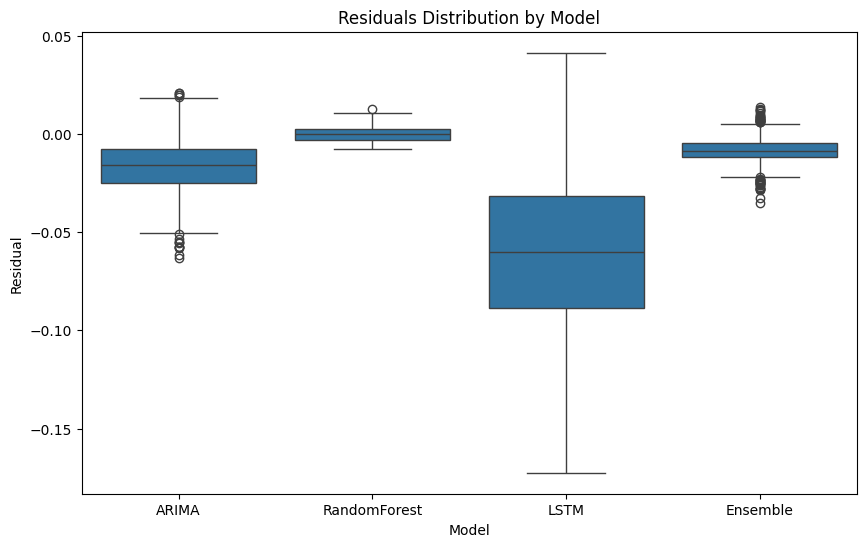

=== Strategy Report ===
Trend-Following Strategy Sharpe Ratio: -0.4730
Trend-Following Strategy Max Drawdown: 0.0901
Trend-Following Strategy CAGR: nan%


In [16]:
visualization_and_reporting(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds, backtest_results)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

=== Step 1: Fetching Data ===
Fetching EUR/USD data...
EURUSD Data Head:
            Close_EURUSD=X  High_EURUSD=X  Low_EURUSD=X  Open_EURUSD=X  \
Date                                                                     
2020-01-01        1.122083       1.122838      1.115947       1.122083   
2020-01-02        1.122083       1.122712      1.116682       1.121894   
2020-01-03        1.117144       1.118068      1.112570       1.117081   
2020-01-06        1.116196       1.120825      1.115810       1.116246   
2020-01-07        1.119799       1.119946      1.113487       1.119583   

            Volume_EURUSD=X  
Date                         
2020-01-01                0  
2020-01-02                0  
2020-01-03                0  
2020-01-06                0  
2020-01-07                0  
Close_EURUSD=X     float64
High_EURUSD=X      float64
Low_EURUSD=X       float64
Open_EURUSD=X      float64
Volume_EURUSD=X      int64
dtype: object
Saved EURUSD.csv to data/

Fetching Gold data...


Saved EURUSD_features.csv to data/
Preprocessing completed and features saved to CSV.

=== Step 3: Exploratory Data Analysis (EDA) ===
Loaded EURUSD_features.csv with shape (1305, 14)
Columns before cleaning: Index(['Close', 'High', 'Low', 'Open', 'Volume', 'MA_20', 'MA_50', 'RSI',
       'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'Signal', 'Returns',
       'Volatility'],
      dtype='object')
First 5 rows before cleaning:
               Close      High       Low      Open  Volume  MA_20  MA_50  \
Date                                                                       
2020-01-01  1.122083  1.122838  1.115947  1.122083       0    NaN    NaN   
2020-01-02  1.122083  1.122712  1.116682  1.121894       0    NaN    NaN   
2020-01-03  1.117144  1.118068  1.112570  1.117081       0    NaN    NaN   
2020-01-06  1.116196  1.120825  1.115810  1.116246       0    NaN    NaN   
2020-01-07  1.119799  1.119946  1.113487  1.119583       0    NaN    NaN   

                  RSI  Bollinger_Upp

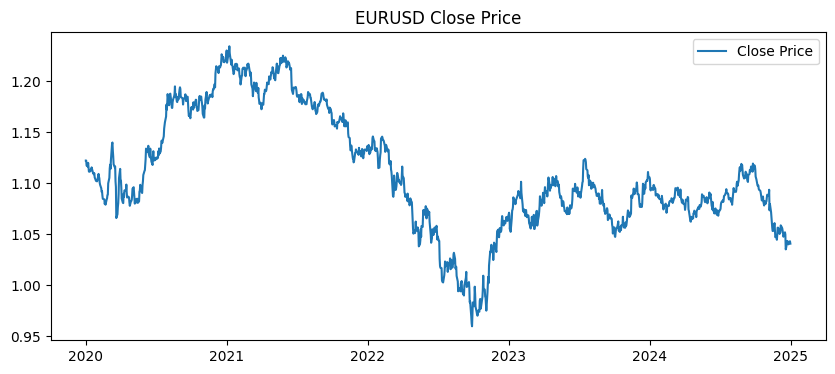


=== Step 4: Market Analysis ===
Loaded EURUSD_features.csv with shape (1305, 14)
Columns before cleaning: Index(['Close', 'High', 'Low', 'Open', 'Volume', 'MA_20', 'MA_50', 'RSI',
       'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'Signal', 'Returns',
       'Volatility'],
      dtype='object')
First 5 rows before cleaning:
               Close      High       Low      Open  Volume  MA_20  MA_50  \
Date                                                                       
2020-01-01  1.122083  1.122838  1.115947  1.122083       0    NaN    NaN   
2020-01-02  1.122083  1.122712  1.116682  1.121894       0    NaN    NaN   
2020-01-03  1.117144  1.118068  1.112570  1.117081       0    NaN    NaN   
2020-01-06  1.116196  1.120825  1.115810  1.116246       0    NaN    NaN   
2020-01-07  1.119799  1.119946  1.113487  1.119583       0    NaN    NaN   

                  RSI  Bollinger_Upper  Bollinger_Lower      MACD    Signal  \
Date                                                       

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 28, 64)              │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 14, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 14, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 405,473 (1.55 MB)

 Trainable params: 405,473 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.2046 - mae: 0.3107
Epoch 1: val_loss improved from inf to 0.00087, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - loss: 0.1998 - mae: 0.3061 - val_loss: 8.6820e-04 - val_mae: 0.0256
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0197 - mae: 0.1090
Epoch 2: val_loss did not improve from 0.00087
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0196 - mae: 0.1089 - val_loss: 0.0020 - val_mae: 0.0436
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0152 - mae: 0.0999
Epoch 3: val_loss did not improve from 0.00087
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0152 - mae: 0.0998 - val_loss: 0.0017 - val_mae: 0.0401
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0136 - mae: 0.0932
Epoch 4: val_loss did not improve from 0.00087
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 0.0136 - mae: 0.0932 - val_loss: 0.0016 - val_mae: 0.0385
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0122 - mae: 0.0869
Epoch 5: val_loss did not improve from 0.00087
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.0122 - m

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0121 - mae: 0.0871 - val_loss: 4.3048e-04 - val_mae: 0.0185
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0113 - mae: 0.0836
Epoch 7: val_loss did not improve from 0.00043
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0113 - mae: 0.0837 - val_loss: 0.0022 - val_mae: 0.0455
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0099 - mae: 0.0797
Epoch 8: val_loss did not improve from 0.00043
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0099 - mae: 0.0798 - val_loss: 0.0076 - val_mae: 0.0867
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0115 - mae: 0.0866
Epoch 9: val_loss did not improve from 0.00043
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0115 - mae: 0.0865 - val_loss: 9.9246e-04 - val_mae: 0.0300
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0103 - mae: 0.0815
Epoch 10: val_loss did not improve from 0.00043
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - loss: 0.0102 

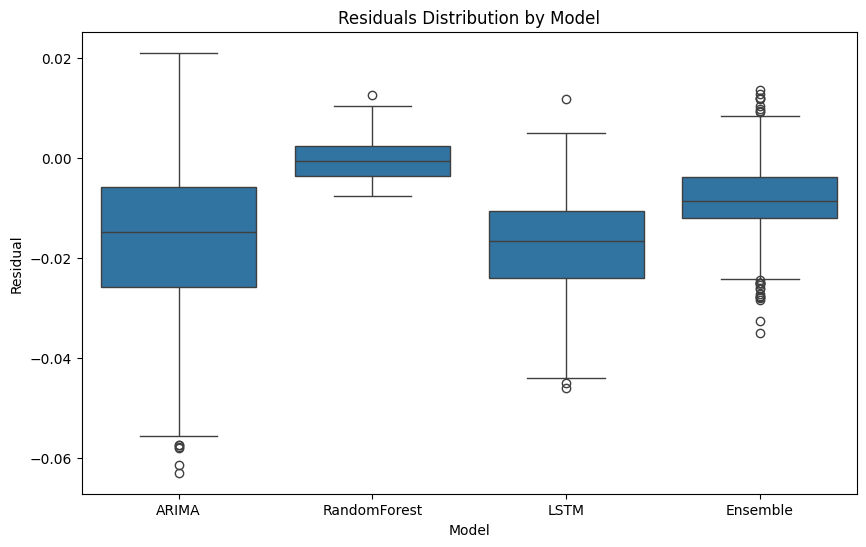

=== Strategy Report ===
Trend-Following Strategy Sharpe Ratio: -0.5494
Trend-Following Strategy Max Drawdown: 0.0809
Trend-Following Strategy CAGR: -3.5423%


In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import coint, grangercausalitytests
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import warnings
warnings.filterwarnings("ignore")
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
DATA_DIR = "data"
def fetch_forex_data_from_yfinance(ticker: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end)
    if df.empty:
        raise ValueError(f"No data found for ticker: {ticker}")
    df.index = pd.to_datetime(df.index)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df
def fetch_commodity_data_from_yfinance(ticker: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end)
    if df.empty:
        raise ValueError(f"No data found for ticker: {ticker}")
    df.dropna(inplace=True)
    df.index = pd.to_datetime(df.index)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df
def save_data_to_csv(df: pd.DataFrame, filename: str):
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
    file_path = os.path.join(DATA_DIR, filename)
    df.to_csv(file_path)
    print(f"Saved {filename} to {DATA_DIR}/")
def load_data_from_csv(filename: str) -> pd.DataFrame:
    file_path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(file_path):
        print(f"File {filename} does not exist in {DATA_DIR}.")
        return pd.DataFrame()
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    print(f"Loaded {filename} with shape {df.shape}")
    print("Columns before cleaning:", df.columns)
    print("First 5 rows before cleaning:")
    print(df.head())
    print("Data types before conversion:")
    print(df.dtypes)
    df.columns = df.columns.str.strip()
    rename_map = {}
    for col in df.columns:
        if '_' in col and ('=X' in col or '=F' in col):
            main_col = col.split('_')[0]
            rename_map[col] = main_col
        else:
            rename_map[col] = col
    df.rename(columns=rename_map, inplace=True)
    print("Columns after renaming:", df.columns)
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    non_numeric_cols = df.select_dtypes(include=['object']).columns
    if len(non_numeric_cols) > 0:
        print(f"Non-numeric columns after conversion: {list(non_numeric_cols)}")
    df_before = df.shape[0]
    if 'Close' in df.columns:
        df.dropna(subset=['Close'], inplace=True)
    else:
        print("Warning: 'Close' column not found. Skipping dropna based on 'Close'.")
    df_after = df.shape[0]
    print(f"Dropped {df_before - df_after} rows due to NaN in 'Close'")
    print(f"After conversion and dropping NaNs, {filename} has shape {df.shape}")
    return df
def main_data_fetching():
    print("=== Step 1: Fetching Data ===")
    print("Fetching EUR/USD data...")
    try:
        eurusd_df = fetch_forex_data_from_yfinance("EURUSD=X", start="2020-01-01", end="2025-01-01")
        print("EURUSD Data Head:")
        print(eurusd_df.head())
        print(eurusd_df.dtypes)
        save_data_to_csv(eurusd_df, "EURUSD.csv")
    except Exception as e:
        print(f"Error fetching EUR/USD data: {e}")
    print("\nFetching Gold data...")
    try:
        gold_df = fetch_commodity_data_from_yfinance("GC=F", start="2020-01-01", end="2025-01-01")
        print("Gold Data Head:")
        print(gold_df.head())
        print(gold_df.dtypes)
        save_data_to_csv(gold_df, "Gold.csv")
    except Exception as e:
        print(f"Error fetching Gold data: {e}")
    print("Data fetching completed and saved to CSV.")
def clean_and_preprocess_data(df: pd.DataFrame,
                              fill_method: str = 'ffill',
                              drop_duplicates: bool = True,
                              remove_outliers_zscore: float = None,
                              scale_method: str = None) -> pd.DataFrame:
    df = df.copy()
    print("\n=== Data Preprocessing ===")
    if drop_duplicates:
        before_dup = df.shape[0]
        df = df[~df.index.duplicated(keep='first')]
        after_dup = df.shape[0]
        print(f"Dropped {before_dup - after_dup} duplicate rows based on index.")
    print(f"Filling missing values using method: {fill_method}")
    if fill_method == 'ffill':
        df.fillna(method='ffill', inplace=True)
    elif fill_method == 'bfill':
        df.fillna(method='bfill', inplace=True)
    elif fill_method == 'mean':
        df.fillna(df.mean(), inplace=True)
    else:
        print("No filling method applied.")
    if remove_outliers_zscore is not None:
        print(f"Removing outliers based on z-score threshold: {remove_outliers_zscore}")
        numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Volume', errors='ignore')
        if len(numeric_cols) == 0:
            print("No numeric columns available for outlier removal.")
        else:
            z_scores = np.abs(zscore(df[numeric_cols]))
            z_scores = np.nan_to_num(z_scores, nan=np.inf, posinf=np.inf, neginf=np.inf)
            before_outlier = df.shape[0]
            df = df[(z_scores < remove_outliers_zscore).all(axis=1)]
            after_outlier = df.shape[0]
            print(f"Removed {before_outlier - after_outlier} outlier rows based on z-score.")
    if scale_method is not None:
        print(f"Scaling data using method: {scale_method}")
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) == 0:
            print("No numeric columns available for scaling.")
        else:
            if scale_method == 'standard':
                scaler = StandardScaler()
                df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
            elif scale_method == 'minmax':
                scaler = MinMaxScaler()
                df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
            else:
                print("No scaling method applied.")
    print("Data cleaning and preprocessing completed.")
    return df
def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    print("\nAdding technical indicators...")
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    window_length = 14
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=window_length - 1, adjust=False).mean()
    ema_down = down.ewm(com=window_length - 1, adjust=False).mean()
    rs = ema_up / ema_down
    df['RSI'] = 100 - (100 / (1 + rs))
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = rolling_mean + (rolling_std * 2)
    df['Bollinger_Lower'] = rolling_mean - (rolling_std * 2)
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window=20).std() * np.sqrt(20)
    print("Technical indicators added.")
    return df
def main_data_preprocessing():
    print("\n=== Step 2: Preprocessing Data ===")
    eurusd_df = load_data_from_csv("EURUSD.csv")
    if eurusd_df.empty:
        print("EURUSD DataFrame is empty after loading. Check previous steps for issues.")
        return
    eurusd_cleaned = clean_and_preprocess_data(
        eurusd_df,
        fill_method='ffill',
        drop_duplicates=True,
        remove_outliers_zscore=3.0,
        scale_method=None
    )
    print(f"EURUSD Cleaned DataFrame shape: {eurusd_cleaned.shape}")
    if eurusd_cleaned.empty:
        print("EURUSD Cleaned DataFrame is empty after preprocessing. Check data integrity.")
        return
    eurusd_features = add_technical_indicators(eurusd_cleaned)
    print(f"EURUSD Features DataFrame shape: {eurusd_features.shape}")
    if eurusd_features.empty:
        print("EURUSD Features DataFrame is empty after adding technical indicators.")
        return
    save_data_to_csv(eurusd_features, "EURUSD_features.csv")
    print("Preprocessing completed and features saved to CSV.")
def exploratory_data_analysis(df: pd.DataFrame, asset_name: str):
    print(f"\n=== Exploratory Data Analysis (EDA) for {asset_name} ===")
    print("Head:\n", df.head(), "\n")
    print("Describe:\n", df.describe(), "\n")
    print("Info:")
    print(df.info(), "\n")
    plt.figure(figsize=(10, 4))
    plt.plot(df['Close'], label='Close Price')
    plt.title(f'{asset_name} Close Price')
    plt.legend()
    plt.show()
    corr = df.corr()
    fig = px.imshow(
        corr, text_auto=True, aspect="auto",
        title=f"{asset_name} Correlation Matrix"
    )
    fig.show()
def main_eda():
    print("\n=== Step 3: Exploratory Data Analysis (EDA) ===")
    eurusd_df = load_data_from_csv("EURUSD_features.csv")
    if eurusd_df.empty:
        print("EURUSD Features DataFrame is empty. Cannot perform EDA.")
        return
    exploratory_data_analysis(eurusd_df, "EURUSD")
def market_analysis(df1: pd.DataFrame,
                    df2: pd.DataFrame,
                    col_name: str = "Close",
                    label1: str = "EURUSD",
                    label2: str = "Gold"):
    print("\n=== Market Analysis ===")
    merged = pd.DataFrame()
    merged[label1] = df1[col_name].copy()
    merged[label2] = df2[col_name].copy()
    merged.dropna(inplace=True)
    if merged.empty:
        print("Merged DataFrame is empty. Cannot perform market analysis.")
        return
    corr_val = merged.corr().iloc[0, 1]
    print(f"Correlation between {label1} and {label2}: {corr_val:.4f}")
    max_lag = 5
    print(f"\nGranger causality test (max_lag={max_lag}):")
    try:
        granger_result = grangercausalitytests(merged[[label1, label2]], maxlag=max_lag, verbose=False)
        for lag, res in granger_result.items():
            p_value = res[0]['ssr_ftest'][1]
            print(f"Lag {lag}: p-value = {p_value:.4f}")
    except Exception as e:
        print(f"Granger causality test failed: {e}")
    try:
        coint_score, p_value, _ = coint(merged[label1], merged[label2])
        print(f"\nCointegration test: statistic={coint_score:.4f}, p-value={p_value:.4f}\n")
    except Exception as e:
        print(f"Cointegration test failed: {e}")
def main_market_analysis():
    print("\n=== Step 4: Market Analysis ===")
    eurusd_df = load_data_from_csv("EURUSD_features.csv")
    gold_df = load_data_from_csv("Gold.csv")
    if eurusd_df.empty or gold_df.empty:
        print("One or both DataFrames are empty. Cannot perform market analysis.")
        return
    market_analysis(eurusd_df, gold_df, col_name="Close",
                    label1="EURUSD", label2="Gold")
def train_test_split_time_series(df, test_size=0.2):
    split_index = int(len(df) * (1 - test_size))
    train = df.iloc[:split_index].copy()
    test = df.iloc[split_index:].copy()
    return train, test
def evaluate_predictions(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2
def arima_model(train, test, order=(2,1,2), col_name='Close'):
    model = ARIMA(train[col_name], order=order).fit()
    predictions = model.forecast(steps=len(test))
    return predictions
def random_forest_model(train, test, features, target='Close'):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(train[features], train[target])
    preds = rf.predict(test[features])
    return preds
def ensemble_predictions(preds_list, weights=None):
    preds_arr = np.array(preds_list)
    if weights is None:
        weights = [1.0 / len(preds_list)] * len(preds_list)
    weighted_preds = np.tensordot(preds_arr, weights, axes=((0), (0)))
    return weighted_preds
def prepare_sequence_data(df, features, target, window_size=30):
    data = df.copy()
    X_list, y_list = [], []
    data = data.dropna(subset=features + [target])
    for i in range(window_size, len(data)):
        X_list.append(data[features].iloc[i-window_size:i].values)
        y_list.append(data[target].iloc[i])
    X_arr = np.array(X_list)
    y_arr = np.array(y_list)
    return X_arr, y_arr
def build_advanced_lstm(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()
    return model
def deep_learning_model(train, test, features, target='Close', epochs=50, window_size=30):
    X_train, y_train = prepare_sequence_data(train, features, target, window_size)
    X_test, y_test = prepare_sequence_data(test, features, target, window_size)
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    model = build_advanced_lstm((X_train.shape[1], X_train.shape[2]))
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    preds = model.predict(X_test).flatten()
    return preds, y_test
def main_modeling():
    print("\n=== Step 5: Modeling & Prediction ===")
    df = load_data_from_csv("EURUSD_features.csv")
    if df.empty:
        print("EURUSD Features DataFrame is empty. Cannot proceed with modeling.")
        return None, None, None, None, None
    features = ['MA_20', 'MA_50', 'RSI', 'MACD', 'Signal', 'Volatility']
    if not all(feature in df.columns for feature in features):
        print("Not all features are present in the DataFrame. Check preprocessing steps.")
        print(f"Available columns: {df.columns.tolist()}")
        return None, None, None, None, None
    df.dropna(inplace=True)
    train_df, test_df = train_test_split_time_series(df)
    print(f"Training Data Shape: {train_df.shape}")
    print(f"Testing Data Shape: {test_df.shape}")
    try:
        arima_preds = arima_model(train_df, test_df, order=(2,1,2), col_name='Close')
        print("ARIMA model predictions completed.")
    except Exception as e:
        print(f"ARIMA model failed: {e}")
        arima_preds = None
    try:
        rf_preds = random_forest_model(train_df, test_df, features, target='Close')
        print("Random Forest model predictions completed.")
    except Exception as e:
        print(f"Random Forest model failed: {e}")
        rf_preds = None
    try:
        lstm_preds, lstm_true = deep_learning_model(
            train_df, test_df, features, target='Close', epochs=50, window_size=30
        )
        print("Improved LSTM model predictions completed.")
        window_size = 30
        aligned_test_df = test_df.iloc[window_size:].copy()
        print(f"LSTM aligned Test DataFrame shape: {aligned_test_df.shape}")
    except Exception as e:
        print(f"LSTM model failed: {e}")
        lstm_preds, aligned_test_df = None, None
    if arima_preds is not None and rf_preds is not None:
        if aligned_test_df is not None:
            arima_preds_aligned = arima_preds[window_size:]
            rf_preds_aligned = rf_preds[window_size:]
            ensemble_preds = ensemble_predictions([arima_preds_aligned, rf_preds_aligned], weights=[0.5, 0.5])
        else:
            ensemble_preds = ensemble_predictions([arima_preds, rf_preds], weights=[0.5, 0.5])
        print("Ensemble (ARIMA + Random Forest) predictions completed.")
    else:
        print("Ensemble model not created due to missing individual model predictions.")
        ensemble_preds = None
    if arima_preds is not None:
        if aligned_test_df is not None:
            arima_rmse, arima_mae, arima_r2 = evaluate_predictions(aligned_test_df['Close'], arima_preds_aligned)
        else:
            arima_rmse, arima_mae, arima_r2 = evaluate_predictions(test_df['Close'], arima_preds)
        print(f"ARIMA        -> RMSE: {arima_rmse:.4f}, MAE: {arima_mae:.4f}, R2: {arima_r2:.4f}")
    else:
        print("ARIMA predictions are not available.")
    if rf_preds is not None:
        if aligned_test_df is not None:
            rf_preds_aligned = rf_preds[window_size:]
            rf_rmse, rf_mae, rf_r2 = evaluate_predictions(aligned_test_df['Close'], rf_preds_aligned)
        else:
            rf_rmse, rf_mae, rf_r2 = evaluate_predictions(test_df['Close'], rf_preds)
        print(f"RandomForest -> RMSE: {rf_rmse:.4f}, MAE: {rf_mae:.4f}, R2: {rf_r2:.4f}")
    else:
        print("Random Forest predictions are not available.")
    if lstm_preds is not None and lstm_true is not None:
        lstm_rmse, lstm_mae, lstm_r2 = evaluate_predictions(lstm_true, lstm_preds)
        print(f"LSTM         -> RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}, R2: {lstm_r2:.4f}")
    else:
        print("LSTM predictions are not available.")
    if ensemble_preds is not None:
        if aligned_test_df is not None:
            ensemble_rmse, ensemble_mae, ensemble_r2 = evaluate_predictions(aligned_test_df['Close'], ensemble_preds)
        else:
            ensemble_rmse, ensemble_mae, ensemble_r2 = evaluate_predictions(test_df['Close'], ensemble_preds)
        print(f"Ensemble(ARIMA,RF) -> RMSE: {ensemble_rmse:.4f}, MAE: {ensemble_mae:.4f}, R2: {ensemble_r2:.4f}")
    else:
        print("Ensemble predictions are not available due to missing individual model predictions.")
    if aligned_test_df is not None:
        final_test_df = aligned_test_df
    else:
        final_test_df = test_df
    return final_test_df, arima_preds_aligned if arima_preds is not None and aligned_test_df is not None else arima_preds, \
           rf_preds_aligned if rf_preds is not None and aligned_test_df is not None else rf_preds, \
           lstm_preds, ensemble_preds
def trend_following_strategy(df: pd.DataFrame, short_window=20, long_window=50):
    df = df.copy()
    print("\nApplying Trend-Following Strategy...")
    required_cols = ['MA_20', 'MA_50']
    for col in required_cols:
        if col not in df.columns:
            print(f"Required column '{col}' not found in DataFrame.")
            return df
    df['Signal'] = np.where(df['MA_20'] > df['MA_50'], 1.0, -1.0)
    df['Position'] = df['Signal'].shift(1).fillna(0)
    print("Trend-Following Strategy applied.")
    return df
def mean_reversion_strategy(df: pd.DataFrame):
    df = df.copy()
    print("\nApplying Mean Reversion Strategy...")
    required_cols = ['Bollinger_Lower', 'Bollinger_Upper']
    for col in required_cols:
        if col not in df.columns:
            print(f"Required column '{col}' not found in DataFrame.")
            return df
    df['Signal'] = 0.0
    df['Signal'] = np.where(df['Close'] < df['Bollinger_Lower'], 1.0, df['Signal'])
    df['Signal'] = np.where(df['Close'] > df['Bollinger_Upper'], -1.0, df['Signal'])
    df['Position'] = df['Signal'].shift(1).fillna(0)
    print("Mean Reversion Strategy applied.")
    return df
def ensemble_strategy(df: pd.DataFrame, preds_df: pd.DataFrame):
    df = df.copy()
    print("\nApplying Ensemble Strategy...")
    if preds_df.empty:
        print("Predictions DataFrame is empty. Cannot apply Ensemble Strategy.")
        return df
    df['Signal'] = np.sign(preds_df.mean(axis=1))
    df['Position'] = df['Signal'].shift(1).fillna(0)
    print("Ensemble Strategy applied.")
    return df
def backtest_strategy(df: pd.DataFrame, col_close='Close',
                      position_col='Position',
                      transaction_cost=0.0001):
    df = df.copy()
    print("\n=== Backtesting Strategy ===")
    required_cols = [col_close, position_col]
    for col in required_cols:
        if col not in df.columns:
            print(f"Required column '{col}' not found in DataFrame.")
            return df, None, None, None
    df['Market_Return'] = df[col_close].pct_change().fillna(0)
    df['Strategy_Return'] = df[position_col] * df['Market_Return']
    df['Strategy_Return_After_Cost'] = (
        df['Strategy_Return']
        - transaction_cost * abs(df[position_col].diff().fillna(0))
    )
    df['Strategy_Return_After_Cost'].fillna(0, inplace=True)
    df['Cumulative_Market'] = (1 + df['Market_Return']).cumprod()
    df['Cumulative_Strategy'] = (1 + df['Strategy_Return_After_Cost']).cumprod()
    df['Cumulative_Strategy'].fillna(method='ffill', inplace=True)
    df['Cumulative_Strategy'].fillna(1, inplace=True)
    annual_factor = 252
    strategy_mean = df['Strategy_Return_After_Cost'].mean()
    strategy_std = df['Strategy_Return_After_Cost'].std()
    if strategy_std != 0:
        sharpe_ratio = (strategy_mean / strategy_std) * np.sqrt(annual_factor)
    else:
        sharpe_ratio = 0.0
    max_drawdown = (df['Cumulative_Strategy'].cummax() - df['Cumulative_Strategy']).max()
    if len(df) > 0 and df['Cumulative_Strategy'].iloc[0] > 0:
        cagr = (df['Cumulative_Strategy'].iloc[-1] / df['Cumulative_Strategy'].iloc[0])**(1/(len(df)/annual_factor)) - 1
    else:
        cagr = np.nan
    return df, sharpe_ratio, max_drawdown, cagr
def main_backtest(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds):
    print("\n=== Step 6: Backtesting Strategies ===")
    strategy_df = trend_following_strategy(test_df)
    results, sharpe, mdd, cagr = backtest_strategy(strategy_df)
    if sharpe is not None:
        print(f"Trend-Following -> Sharpe: {sharpe:.4f}, Max DD: {mdd:.4f}, CAGR: {cagr*100:.4f}%")
    else:
        print("Backtesting failed due to missing data.")
    return results
def visualization_and_reporting(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds, backtest_results):
    print("\n=== Step 8: Visualization & Reporting ===")
    if arima_preds is None and rf_preds is None and lstm_preds is None and ensemble_preds is None:
        print("No predictions available for visualization.")
        return
    predictions_df = pd.DataFrame({
        'Date': test_df.index,
        'Actual_Close': test_df['Close']
    })
    if arima_preds is not None:
        predictions_df['ARIMA_Predicted'] = arima_preds
    if rf_preds is not None:
        predictions_df['RandomForest_Predicted'] = rf_preds
    if lstm_preds is not None:
        predictions_df['LSTM_Predicted'] = lstm_preds
    if ensemble_preds is not None:
        predictions_df['Ensemble_Predicted'] = ensemble_preds
    lengths = {
        'test_df': len(test_df),
        'ARIMA_Predicted': len(predictions_df['ARIMA_Predicted']) if 'ARIMA_Predicted' in predictions_df.columns else 'N/A',
        'RandomForest_Predicted': len(predictions_df['RandomForest_Predicted']) if 'RandomForest_Predicted' in predictions_df.columns else 'N/A',
        'LSTM_Predicted': len(predictions_df['LSTM_Predicted']) if 'LSTM_Predicted' in predictions_df.columns else 'N/A',
        'Ensemble_Predicted': len(predictions_df['Ensemble_Predicted']) if 'Ensemble_Predicted' in predictions_df.columns else 'N/A'
    }
    print("\n=== Prediction Lengths ===")
    for key, value in lengths.items():
        print(f"{key}: {value}")
    min_length = len(test_df)
    for pred in ['ARIMA_Predicted', 'RandomForest_Predicted', 'LSTM_Predicted', 'Ensemble_Predicted']:
        if pred in predictions_df.columns:
            min_length = min(min_length, len(predictions_df[pred]))
    print(f"\nMinimum prediction length: {min_length}")
    if min_length < len(test_df):
        print(f"Trimming test_df and predictions to the first {min_length} entries.")
        predictions_df = predictions_df.iloc[:min_length]
    predictions_df.set_index('Date', inplace=True)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Actual_Close'],
                             mode='lines', name='Actual'))
    if 'ARIMA_Predicted' in predictions_df.columns:
        fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['ARIMA_Predicted'],
                                 mode='lines', name='ARIMA'))
    if 'RandomForest_Predicted' in predictions_df.columns:
        fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['RandomForest_Predicted'],
                                 mode='lines', name='Random Forest'))
    if 'LSTM_Predicted' in predictions_df.columns:
        fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['LSTM_Predicted'],
                                 mode='lines', name='LSTM'))
    if 'Ensemble_Predicted' in predictions_df.columns:
        fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Ensemble_Predicted'],
                                 mode='lines', name='Ensemble'))
    fig.update_layout(title='Actual vs Predicted EUR/USD Close Prices',
                      xaxis_title='Date',
                      yaxis_title='EUR/USD Price',
                      hovermode='x unified')
    fig.show()
    if 'ARIMA_Predicted' in predictions_df.columns:
        predictions_df['ARIMA_Residual'] = predictions_df['Actual_Close'] - predictions_df['ARIMA_Predicted']
    if 'RandomForest_Predicted' in predictions_df.columns:
        predictions_df['RandomForest_Residual'] = predictions_df['Actual_Close'] - predictions_df['RandomForest_Predicted']
    if 'LSTM_Predicted' in predictions_df.columns:
        predictions_df['LSTM_Residual'] = predictions_df['Actual_Close'] - predictions_df['LSTM_Predicted']
    if 'Ensemble_Predicted' in predictions_df.columns:
        predictions_df['Ensemble_Residual'] = predictions_df['Actual_Close'] - predictions_df['Ensemble_Predicted']
    residual_models = ['ARIMA_Residual', 'RandomForest_Residual', 'LSTM_Residual', 'Ensemble_Residual']
    for residual in residual_models:
        if residual in predictions_df.columns:
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df[residual],
                                     mode='lines', name=residual))
            fig.update_layout(title=f'Residuals Over Time - {residual.split("_")[0]} Model',
                              xaxis_title='Date',
                              yaxis_title='Residual EUR/USD Price',
                              hovermode='x unified')
            fig.show()
    if 'Cumulative_Strategy' in backtest_results.columns and 'Cumulative_Market' in backtest_results.columns:
        if not backtest_results['Cumulative_Strategy'].isna().any() and not backtest_results['Cumulative_Market'].isna().any():
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=backtest_results.index, y=backtest_results['Cumulative_Market'],
                                     mode='lines', name='Market Cumulative Returns'))
            fig.add_trace(go.Scatter(x=backtest_results.index, y=backtest_results['Cumulative_Strategy'],
                                     mode='lines', name='Strategy Cumulative Returns'))
            fig.update_layout(title='Strategy vs Market Cumulative Returns',
                              xaxis_title='Date',
                              yaxis_title='Cumulative Returns',
                              hovermode='x unified')
            fig.show()
        else:
            print("Cumulative returns contain NaN values. Skipping cumulative returns plot.")
    else:
        print("Cumulative_Strategy or Cumulative_Market columns not found. Skipping cumulative returns plot.")
    model_preds = ['ARIMA_Predicted', 'RandomForest_Predicted', 'LSTM_Predicted', 'Ensemble_Predicted']
    existing_preds = [pred for pred in model_preds if pred in predictions_df.columns]
    if len(existing_preds) >= 2:
        corr_matrix = predictions_df[existing_preds].corr()
        fig = px.imshow(corr_matrix, text_auto=True, aspect="auto",
                        title="Correlation Matrix of Model Predictions",
                        color_continuous_scale='RdBu_r', zmin=-1, zmax=1)
        fig.show()
    else:
        print("Not enough model predictions available to plot correlation heatmap.")
    models = ['ARIMA', 'RandomForest', 'LSTM', 'Ensemble']
    for model in models:
        pred_col = f'{model}_Predicted'
        if pred_col in predictions_df.columns:
            fig = px.scatter(predictions_df, x='Actual_Close', y=pred_col,
                             trendline="ols",
                             title=f'Actual vs Predicted Close Prices - {model}',
                             labels={'Actual_Close': 'Actual Close', pred_col: 'Predicted Close'})
            fig.show()
    residuals = []
    residual_labels = []
    for residual in residual_models:
        if residual in predictions_df.columns:
            residuals.append(predictions_df[residual])
            residual_labels.append(residual.split('_')[0])
    if residuals:
        residuals_df = pd.DataFrame({
            'Residual': pd.concat(residuals),
            'Model': np.repeat(residual_labels, [len(r) for r in residuals])
        })
        plt.figure(figsize=(10,6))
        sns.boxplot(x='Model', y='Residual', data=residuals_df)
        plt.title('Residuals Distribution by Model')
        plt.show()
    if residuals:
        fig = go.Figure()
        for residual, label in zip(residuals, residual_labels):
            fig.add_trace(go.Histogram(x=residual, name=f'{label} Residual', opacity=0.75))
        fig.update_layout(barmode='overlay',
                          title='Distribution of Residuals by Model',
                          xaxis_title='Residual EUR/USD Price',
                          yaxis_title='Count',
                          hovermode='x unified')
        fig.show()
    print("=== Strategy Report ===")
    if 'Strategy_Return_After_Cost' in backtest_results.columns:
        sharpe_ratio = (backtest_results['Strategy_Return_After_Cost'].mean() /
                        backtest_results['Strategy_Return_After_Cost'].std()) * np.sqrt(252)
        cumulative = backtest_results['Cumulative_Strategy']
        rolling_max = cumulative.cummax()
        drawdown = rolling_max - cumulative
        max_drawdown = drawdown.max()
        start_date = backtest_results.index[0]
        end_date = backtest_results.index[-1]
        num_years = (end_date - start_date).days / 365.25
        if num_years > 0 and cumulative.iloc[0] > 0:
            cagr = (cumulative.iloc[-1] / cumulative.iloc[0])**(1/num_years) - 1
        else:
            cagr = np.nan
        print(f"Trend-Following Strategy Sharpe Ratio: {sharpe_ratio:.4f}")
        print(f"Trend-Following Strategy Max Drawdown: {max_drawdown:.4f}")
        if not np.isnan(cagr):
            print(f"Trend-Following Strategy CAGR: {cagr*100:.4f}%")
        else:
            print(f"Trend-Following Strategy CAGR: nan%")
    else:
        print("Strategy Return data not available.")
def main():
    main_data_fetching()
    main_data_preprocessing()
    main_eda()
    main_market_analysis()
    test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds = main_modeling()
    if test_df is not None:
        backtest_results = main_backtest(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds)
    else:
        print("Test DataFrame is not available. Skipping backtesting.")
        backtest_results = None
    if backtest_results is not None:
        visualization_and_reporting(test_df, arima_preds, rf_preds, lstm_preds, ensemble_preds, backtest_results)
    else:
        print("Backtest results are not available. Skipping visualization and reporting.")
if __name__ == "__main__":
    main()


In [18]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.8 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

=== Step 1: Fetching Data ===
Fetching EUR/USD data...
EURUSD Data Head:
            Close_EURUSD=X  High_EURUSD=X  Low_EURUSD=X  Open_EURUSD=X  \
Date                                                                     
2020-01-01        1.122083       1.122838      1.115947       1.122083   
2020-01-02        1.122083       1.122712      1.116682       1.121894   
2020-01-03        1.117144       1.118068      1.112570       1.117081   
2020-01-06        1.116196       1.120825      1.115810       1.116246   
2020-01-07        1.119799       1.119946      1.113487       1.119583   

            Volume_EURUSD=X  
Date                         
2020-01-01                0  
2020-01-02                0  
2020-01-03                0  
2020-01-06                0  
2020-01-07                0  
Close_EURUSD=X     float64
High_EURUSD=X      float64
Low_EURUSD=X       float64
Open_EURUSD=X      float64
Volume_EURUSD=X      int64
dtype: object
Saved EURUSD.csv to data/

Fetching Gold data...


Describe:
              Close         High          Low         Open  Volume  \
count  1305.000000  1305.000000  1305.000000  1305.000000  1305.0   
mean      1.108625     1.111972     1.105054     1.108601     0.0   
std       0.058197     0.057771     0.058559     0.058178     0.0   
min       0.959619     0.967006     0.954016     0.959619     0.0   
25%       1.073272     1.075755     1.070034     1.073272     0.0   
50%       1.094319     1.097021     1.090667     1.094331     0.0   
75%       1.159555     1.161170     1.156363     1.159366     0.0   
max       1.234111     1.235025     1.226693     1.233776     0.0   

             MA_20        MA_50          RSI  Bollinger_Upper  \
count  1286.000000  1256.000000  1303.000000      1286.000000   
mean      1.109054     1.109780    48.617287         1.125984   
std       0.057637     0.056963    12.249877         0.056198   
min       0.976781     0.987973     0.000000         0.995442   
25%       1.075133     1.077120    39.9096

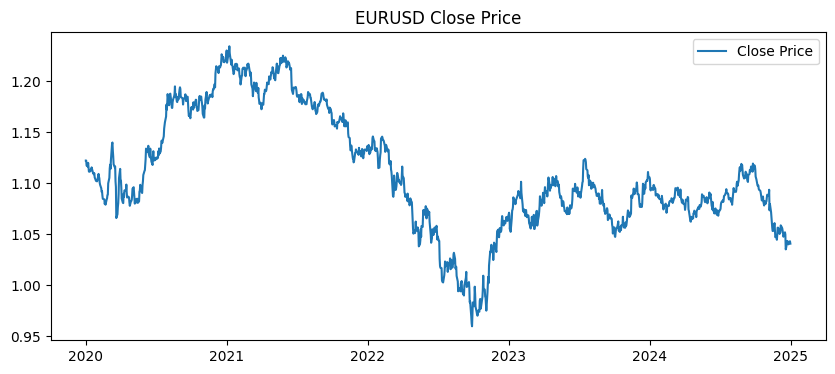


=== Step 4: Market Analysis ===
Loaded EURUSD_features.csv with shape (1305, 14)
Columns before cleaning: Index(['Close', 'High', 'Low', 'Open', 'Volume', 'MA_20', 'MA_50', 'RSI',
       'Bollinger_Upper', 'Bollinger_Lower', 'MACD', 'Signal', 'Returns',
       'Volatility'],
      dtype='object')
First 5 rows before cleaning:
               Close      High       Low      Open  Volume  MA_20  MA_50  \
Date                                                                       
2020-01-01  1.122083  1.122838  1.115947  1.122083       0    NaN    NaN   
2020-01-02  1.122083  1.122712  1.116682  1.121894       0    NaN    NaN   
2020-01-03  1.117144  1.118068  1.112570  1.117081       0    NaN    NaN   
2020-01-06  1.116196  1.120825  1.115810  1.116246       0    NaN    NaN   
2020-01-07  1.119799  1.119946  1.113487  1.119583       0    NaN    NaN   

                  RSI  Bollinger_Upper  Bollinger_Lower      MACD    Signal  \
Date                                                       

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 28, 64)              │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 14, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 14, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 405,473 (1.55 MB)

 Trainable params: 405,473 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.3199 - mae: 0.3871
Epoch 1: val_loss improved from inf to 0.01279, saving model to best_lstm_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 226ms/step - loss: 0.3119 - mae: 0.3803 - val_loss: 0.0128 - val_mae: 0.1122
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0194 - mae: 0.1099
Epoch 2: val_loss improved from 0.01279 to 0.00012, saving model to best_lstm_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0194 - mae: 0.1097 - val_loss: 1.2473e-04 - val_mae: 0.0089
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0188 - mae: 0.1094
Epoch 3: val_loss did not improve from 0.00012
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 0.0187 - mae: 0.1093 - val_loss: 2.6454e-04 - val_mae: 0.0130
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0169 - mae: 0.1041
Epoch 4: val_loss did not improve from 0.00012
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0168 - mae: 0.1039 - val_loss: 0.0014 - val_mae: 0.0354
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0137 - mae: 0.0940
Epoch 5: val_loss did not improve from 0.00012
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0137 - mae: 0.0939 - val_loss: 0.0015 - val_mae: 0.0380
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0123 - mae: 0.0884
Epoch 6: val_loss did not improve from 0.00012
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0123 -

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 28, 64)              │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 14, 256)             │         148,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 14, 128)             │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 306,017 (1.17 MB)

 Trainable params: 306,017 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.3764 - mae: 0.4356
Epoch 1: val_loss improved from inf to 0.07048, saving model to best_gru_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - loss: 0.3681 - mae: 0.4296 - val_loss: 0.0705 - val_mae: 0.2652
Epoch 2/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0519 - mae: 0.1840
Epoch 2: val_loss improved from 0.07048 to 0.04209, saving model to best_gru_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0516 - mae: 0.1834 - val_loss: 0.0421 - val_mae: 0.2045
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0396 - mae: 0.1595
Epoch 3: val_loss improved from 0.04209 to 0.00630, saving model to best_gru_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 0.0394 - mae: 0.1590 - val_loss: 0.0063 - val_mae: 0.0788
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0252 - mae: 0.1266
Epoch 4: val_loss did not improve from 0.00630
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0252 - mae: 0.1265 - val_loss: 0.0120 - val_mae: 0.1088
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0221 - mae: 0.1189
Epoch 5: val_loss did not improve from 0.00630
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0220 - mae: 0.1187 - val_loss: 0.0182 - val_mae: 0.1342
Epoch 6/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0214 - mae: 0.1181
Epoch 6: val_loss did not improve from 0.00630
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0214 - mae: 0.1180 - val_loss: 0.0317 - val_mae: 0.1778
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0195 - mae: 0.1109
Epoch 7: val_loss did not improve from 0.00630
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0194 - mae: 0.110

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - loss: 0.0155 - mae: 0.1000 - val_loss: 0.0043 - val_mae: 0.0651
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0126 - mae: 0.0903
Epoch 13: val_loss did not improve from 0.00433
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - loss: 0.0125 - mae: 0.0902 - val_loss: 0.0119 - val_mae: 0.1088
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0125 - mae: 0.0901
Epoch 14: val_loss did not improve from 0.00433
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 0.0125 - mae: 0.0901 - val_loss: 0.0088 - val_mae: 0.0930
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0117 - mae: 0.0855
Epoch 15: val_loss did not improve from 0.00433
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0117 - mae: 0.0856 - val_loss: 0.0050 - val_mae: 0.0694
Epoch 16/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0118 - mae: 0.0859
Epoch 16: val_loss improved from 0.00433 to 0.00261, saving model to best_gru_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 0.0118 - mae: 0.0860 - val_loss: 0.0026 - val_mae: 0.0497
Epoch 17/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.0129 - mae: 0.0900
Epoch 17: val_loss did not improve from 0.00261
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - loss: 0.0129 - mae: 0.0900 - val_loss: 0.0142 - val_mae: 0.1187
Epoch 18/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0106 - mae: 0.0836
Epoch 18: val_loss improved from 0.00261 to 0.00108, saving model to best_gru_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0106 - mae: 0.0836 - val_loss: 0.0011 - val_mae: 0.0313
Epoch 19/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0121 - mae: 0.0893
Epoch 19: val_loss did not improve from 0.00108
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0121 - mae: 0.0892 - val_loss: 0.0142 - val_mae: 0.1188
Epoch 20/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0120 - mae: 0.0887
Epoch 20: val_loss did not improve from 0.00108
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0120 - mae: 0.0887 - val_loss: 0.0090 - val_mae: 0.0946
Epoch 21/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0115 - mae: 0.0859
Epoch 21: val_loss did not improve from 0.00108
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0114 - mae: 0.0859 - val_loss: 0.0038 - val_mae: 0.0604
Epoch 22/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0115 - mae: 0.0883
Epoch 22: val_loss did not improve from 0.00108
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0115 - ma

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 30, 6)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 30, 6)          │          6,918 │ input_layer_8[0][0],   │
│ (MultiHeadAttention)      │                        │                │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 30, 6)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 30, 6)          │              0 │ dropout_10[0][0],      │
│                           │                        │                │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 30, 6)          │             12 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 30, 64)         │            448 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 30, 64)         │              0 │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 30, 6)          │            390 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 30, 6)          │              0 │ layer_normalization[0… │
│                           │                        │                │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 30, 6)          │             12 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 30, 6)          │          6,918 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 30, 6)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 30, 6)          │              0 │ dropout_13[0][0],      │
│                           │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 30, 6)          │             12 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 30, 64)         │            448 │ layer_normalization_2… │
├──────────────────────

 Total params: 16,073 (62.79 KB)

 Trainable params: 16,073 (62.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.2034 - mae: 0.3797
Epoch 1: val_loss improved from inf to 0.00055, saving model to best_transformer_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - loss: 0.1952 - mae: 0.3690 - val_loss: 5.4610e-04 - val_mae: 0.0177
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0279 - mae: 0.1312
Epoch 2: val_loss did not improve from 0.00055
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0278 - mae: 0.1312 - val_loss: 0.0019 - val_mae: 0.0404
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0255 - mae: 0.1241
Epoch 3: val_loss did not improve from 0.00055
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0255 - mae: 0.1240 - val_loss: 0.0028 - val_mae: 0.0500
Epoch 4/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0192 - mae: 0.1107
Epoch 4: val_loss did not improve from 0.00055
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0192 - mae: 0.1105 - val_loss: 5.9150e-04 - val_mae: 0.0205
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0219 - mae: 0.1155
Epoch 5: val_loss did not improve from 0.00055
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0219 - m

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0163 - mae: 0.1032 - val_loss: 2.6912e-04 - val_mae: 0.0137
Epoch 9/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0160 - mae: 0.1020
Epoch 9: val_loss did not improve from 0.00027
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0160 - mae: 0.1019 - val_loss: 0.0053 - val_mae: 0.0712
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0165 - mae: 0.1024
Epoch 10: val_loss did not improve from 0.00027
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0165 - mae: 0.1024 - val_loss: 0.0025 - val_mae: 0.0475
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0142 - mae: 0.0947
Epoch 11: val_loss did not improve from 0.00027
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0142 - mae: 0.0947 - val_loss: 0.0017 - val_mae: 0.0378
Epoch 12/50
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0151 - mae: 0.0972
Epoch 12: val_loss did not improve from 0.00027
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0151 - m

=== Strategy Report ===
Trend-Following Strategy Sharpe Ratio: -0.6215
Trend-Following Strategy Max Drawdown: 0.0892
Trend-Following Strategy CAGR: -3.8925%

=== Future Predictions Visualization ===


In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import coint, grangercausalitytests
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D, GRU, Input, LayerNormalization, GlobalAveragePooling1D, Add, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pmdarima as pm
from prophet import Prophet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import warnings
warnings.filterwarnings("ignore")
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
DATA_DIR = "data"
def fetch_forex_data_from_yfinance(ticker: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end)
    if df.empty:
        raise ValueError(f"No data found for ticker: {ticker}")
    df.index = pd.to_datetime(df.index)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df
def fetch_commodity_data_from_yfinance(ticker: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end)
    if df.empty:
        raise ValueError(f"No data found for ticker: {ticker}")
    df.dropna(inplace=True)
    df.index = pd.to_datetime(df.index)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df
def save_data_to_csv(df: pd.DataFrame, filename: str):
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
    file_path = os.path.join(DATA_DIR, filename)
    df.to_csv(file_path)
    print(f"Saved {filename} to {DATA_DIR}/")
def load_data_from_csv(filename: str) -> pd.DataFrame:
    file_path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(file_path):
        print(f"File {filename} does not exist in {DATA_DIR}.")
        return pd.DataFrame()
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    print(f"Loaded {filename} with shape {df.shape}")
    print("Columns before cleaning:", df.columns)
    print("First 5 rows before cleaning:")
    print(df.head())
    print("Data types before conversion:")
    print(df.dtypes)
    df.columns = df.columns.str.strip()
    rename_map = {}
    for col in df.columns:
        if '_' in col and ('=X' in col or '=F' in col):
            main_col = col.split('_')[0]
            rename_map[col] = main_col
        else:
            rename_map[col] = col
    df.rename(columns=rename_map, inplace=True)
    print("Columns after renaming:", df.columns)
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    non_numeric_cols = df.select_dtypes(include=['object']).columns
    if len(non_numeric_cols) > 0:
        print(f"Non-numeric columns after conversion: {list(non_numeric_cols)}")
    df_before = df.shape[0]
    if 'Close' in df.columns:
        df.dropna(subset=['Close'], inplace=True)
    else:
        print("Warning: 'Close' column not found. Skipping dropna based on 'Close'.")
    df_after = df.shape[0]
    print(f"Dropped {df_before - df_after} rows due to NaN in 'Close'")
    print(f"After conversion and dropping NaNs, {filename} has shape {df.shape}")
    return df
def main_data_fetching():
    print("=== Step 1: Fetching Data ===")
    print("Fetching EUR/USD data...")
    try:
        eurusd_df = fetch_forex_data_from_yfinance("EURUSD=X", start="2020-01-01", end="2025-01-01")
        print("EURUSD Data Head:")
        print(eurusd_df.head())
        print(eurusd_df.dtypes)
        save_data_to_csv(eurusd_df, "EURUSD.csv")
    except Exception as e:
        print(f"Error fetching EUR/USD data: {e}")
    print("\nFetching Gold data...")
    try:
        gold_df = fetch_commodity_data_from_yfinance("GC=F", start="2020-01-01", end="2025-01-01")
        print("Gold Data Head:")
        print(gold_df.head())
        print(gold_df.dtypes)
        save_data_to_csv(gold_df, "Gold.csv")
    except Exception as e:
        print(f"Error fetching Gold data: {e}")
    print("Data fetching completed and saved to CSV.")
def clean_and_preprocess_data(df: pd.DataFrame,
                              fill_method: str = 'ffill',
                              drop_duplicates: bool = True,
                              remove_outliers_zscore: float = None,
                              scale_method: str = None) -> pd.DataFrame:
    df = df.copy()
    print("\n=== Data Preprocessing ===")
    if drop_duplicates:
        before_dup = df.shape[0]
        df = df[~df.index.duplicated(keep='first')]
        after_dup = df.shape[0]
        print(f"Dropped {before_dup - after_dup} duplicate rows based on index.")
    print(f"Filling missing values using method: {fill_method}")
    if fill_method == 'ffill':
        df.fillna(method='ffill', inplace=True)
    elif fill_method == 'bfill':
        df.fillna(method='bfill', inplace=True)
    elif fill_method == 'mean':
        df.fillna(df.mean(), inplace=True)
    else:
        print("No filling method applied.")
    if remove_outliers_zscore is not None:
        print(f"Removing outliers based on z-score threshold: {remove_outliers_zscore}")
        numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Volume', errors='ignore')
        if len(numeric_cols) == 0:
            print("No numeric columns available for outlier removal.")
        else:
            z_scores = np.abs(zscore(df[numeric_cols]))
            z_scores = np.nan_to_num(z_scores, nan=np.inf, posinf=np.inf, neginf=np.inf)
            before_outlier = df.shape[0]
            df = df[(z_scores < remove_outliers_zscore).all(axis=1)]
            after_outlier = df.shape[0]
            print(f"Removed {before_outlier - after_outlier} outlier rows based on z-score.")
    if scale_method is not None:
        print(f"Scaling data using method: {scale_method}")
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) == 0:
            print("No numeric columns available for scaling.")
        else:
            if scale_method == 'standard':
                scaler = StandardScaler()
                df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
            elif scale_method == 'minmax':
                scaler = MinMaxScaler()
                df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
            else:
                print("No scaling method applied.")
    print("Data cleaning and preprocessing completed.")
    return df
def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    print("\nAdding technical indicators...")
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    window_length = 14
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=window_length - 1, adjust=False).mean()
    ema_down = down.ewm(com=window_length - 1, adjust=False).mean()
    rs = ema_up / ema_down
    df['RSI'] = 100 - (100 / (1 + rs))
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = rolling_mean + (rolling_std * 2)
    df['Bollinger_Lower'] = rolling_mean - (rolling_std * 2)
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window=20).std() * np.sqrt(20)
    print("Technical indicators added.")
    return df
def main_data_preprocessing():
    print("\n=== Step 2: Preprocessing Data ===")
    eurusd_df = load_data_from_csv("EURUSD.csv")
    if eurusd_df.empty:
        print("EURUSD DataFrame is empty after loading. Check previous steps for issues.")
        return
    eurusd_cleaned = clean_and_preprocess_data(
        eurusd_df,
        fill_method='ffill',
        drop_duplicates=True,
        remove_outliers_zscore=3.0,
        scale_method=None
    )
    print(f"EURUSD Cleaned DataFrame shape: {eurusd_cleaned.shape}")
    if eurusd_cleaned.empty:
        print("EURUSD Cleaned DataFrame is empty after preprocessing. Check data integrity.")
        return
    eurusd_features = add_technical_indicators(eurusd_cleaned)
    print(f"EURUSD Features DataFrame shape: {eurusd_features.shape}")
    if eurusd_features.empty:
        print("EURUSD Features DataFrame is empty after adding technical indicators.")
        return
    save_data_to_csv(eurusd_features, "EURUSD_features.csv")
    print("Preprocessing completed and features saved to CSV.")
def exploratory_data_analysis(df: pd.DataFrame, asset_name: str):
    print(f"\n=== Exploratory Data Analysis (EDA) for {asset_name} ===")
    print("Head:\n", df.head(), "\n")
    print("Describe:\n", df.describe(), "\n")
    print("Info:")
    print(df.info(), "\n")
    plt.figure(figsize=(10, 4))
    plt.plot(df['Close'], label='Close Price')
    plt.title(f'{asset_name} Close Price')
    plt.legend()
    plt.show()
    corr = df.corr()
    fig = px.imshow(
        corr, text_auto=True, aspect="auto",
        title=f"{asset_name} Correlation Matrix"
    )
    fig.show()
def main_eda():
    print("\n=== Step 3: Exploratory Data Analysis (EDA) ===")
    eurusd_df = load_data_from_csv("EURUSD_features.csv")
    if eurusd_df.empty:
        print("EURUSD Features DataFrame is empty. Cannot perform EDA.")
        return
    exploratory_data_analysis(eurusd_df, "EURUSD")
def market_analysis(df1: pd.DataFrame,
                    df2: pd.DataFrame,
                    col_name: str = "Close",
                    label1: str = "EURUSD",
                    label2: str = "Gold"):
    print("\n=== Market Analysis ===")
    merged = pd.DataFrame()
    merged[label1] = df1[col_name].copy()
    merged[label2] = df2[col_name].copy()
    merged.dropna(inplace=True)
    if merged.empty:
        print("Merged DataFrame is empty. Cannot perform market analysis.")
        return
    corr_val = merged.corr().iloc[0, 1]
    print(f"Correlation between {label1} and {label2}: {corr_val:.4f}")
    max_lag = 5
    print(f"\nGranger causality test (max_lag={max_lag}):")
    try:
        granger_result = grangercausalitytests(merged[[label1, label2]], maxlag=max_lag, verbose=False)
        for lag, res in granger_result.items():
            p_value = res[0]['ssr_ftest'][1]
            print(f"Lag {lag}: p-value = {p_value:.4f}")
    except Exception as e:
        print(f"Granger causality test failed: {e}")
    try:
        coint_score, p_value, _ = coint(merged[label1], merged[label2])
        print(f"\nCointegration test: statistic={coint_score:.4f}, p-value={p_value:.4f}\n")
    except Exception as e:
        print(f"Cointegration test failed: {e}")
def main_market_analysis():
    print("\n=== Step 4: Market Analysis ===")
    eurusd_df = load_data_from_csv("EURUSD_features.csv")
    gold_df = load_data_from_csv("Gold.csv")
    if eurusd_df.empty or gold_df.empty:
        print("One or both DataFrames are empty. Cannot perform market analysis.")
        return
    market_analysis(eurusd_df, gold_df, col_name="Close",
                    label1="EURUSD", label2="Gold")
def train_test_split_time_series(df, test_size=0.2):
    split_index = int(len(df) * (1 - test_size))
    train = df.iloc[:split_index].copy()
    test = df.iloc[split_index:].copy()
    return train, test
def evaluate_predictions(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2
def arima_model(train, test, order=(2,1,2), col_name='Close'):
    model = ARIMA(train[col_name], order=order).fit()
    predictions = model.forecast(steps=len(test))
    return predictions
def auto_arima_model(train, test, col_name='Close'):
    model = pm.auto_arima(train[col_name], seasonal=False, stepwise=True, suppress_warnings=True)
    predictions = model.predict(n_periods=len(test))
    return predictions
def tuned_random_forest_model(train, test, features, target='Close'):
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    }
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(train[features], train[target])
    best_rf = grid_search.best_estimator_
    preds = best_rf.predict(test[features])
    print("Best parameters for RandomForest:", grid_search.best_params_)
    return preds
def tuned_xgb_model(train, test, features, target='Close'):
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2]
    }
    xgb_model_inst = XGBRegressor(random_state=42, verbosity=0)
    grid_search = GridSearchCV(xgb_model_inst, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(train[features], train[target])
    best_xgb = grid_search.best_estimator_
    preds = best_xgb.predict(test[features])
    print("Best parameters for XGBoost:", grid_search.best_params_)
    return preds
def prophet_model(train, test, col_name='Close'):
    df_train = train[[col_name]].reset_index().rename(columns={'index':'ds', col_name:'y'})
    model = Prophet(daily_seasonality=True)
    model.fit(df_train)
    future = model.make_future_dataframe(periods=len(test), freq='D')
    forecast = model.predict(future)
    preds = forecast['yhat'].tail(len(test)).values
    return preds
def prepare_sequence_data(df, features, target, window_size=30):
    data = df.copy()
    X_list, y_list = [], []
    data = data.dropna(subset=features + [target])
    for i in range(window_size, len(data)):
        X_list.append(data[features].iloc[i-window_size:i].values)
        y_list.append(data[target].iloc[i])
    X_arr = np.array(X_list)
    y_arr = np.array(y_list)
    return X_arr, y_arr
def build_advanced_lstm(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()
    return model
def deep_learning_model(train, test, features, target='Close', epochs=50, window_size=30):
    X_train, y_train = prepare_sequence_data(train, features, target, window_size)
    X_test, y_test = prepare_sequence_data(test, features, target, window_size)
    print(f"LSTM - X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    model = build_advanced_lstm((X_train.shape[1], X_train.shape[2]))
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]
    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    preds = model.predict(X_test).flatten()
    return preds, y_test
def deep_learning_model_gru(train, test, features, target='Close', epochs=50, window_size=30):
    X_train, y_train = prepare_sequence_data(train, features, target, window_size)
    X_test, y_test = prepare_sequence_data(test, features, target, window_size)
    print(f"GRU - X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(32)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ModelCheckpoint('best_gru_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]
    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    preds = model.predict(X_test).flatten()
    return preds, y_test
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    x_ff = Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x_ff)
    x = Add()([x, x_ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x
def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=64, num_transformer_blocks=2, mlp_units=[64], dropout=0.1, mlp_dropout=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    model.summary()
    return model
def deep_learning_transformer_model(train, test, features, target='Close', epochs=50, window_size=30,
                                      head_size=64, num_heads=4, ff_dim=64, num_transformer_blocks=2,
                                      mlp_units=[64], dropout=0.1, mlp_dropout=0.1):
    X_train, y_train = prepare_sequence_data(train, features, target, window_size)
    X_test, y_test = prepare_sequence_data(test, features, target, window_size)
    print(f"Transformer - X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    model = build_transformer_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        head_size=head_size,
        num_heads=num_heads,
        ff_dim=ff_dim,
        num_transformer_blocks=num_transformer_blocks,
        mlp_units=mlp_units,
        dropout=dropout,
        mlp_dropout=mlp_dropout
    )
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ModelCheckpoint('best_transformer_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ]
    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    preds = model.predict(X_test).flatten()
    return preds, y_test
def ensemble_predictions(preds_list, weights=None):
    preds_arr = np.array(preds_list)
    if weights is None:
        weights = [1.0 / len(preds_list)] * len(preds_list)
    weighted_preds = np.tensordot(preds_arr, weights, axes=((0), (0)))
    return weighted_preds
def main_modeling():
    print("\n=== Step 5: Modeling & Prediction ===")
    df = load_data_from_csv("EURUSD_features.csv")
    if df.empty:
        print("EURUSD Features DataFrame is empty. Cannot proceed with modeling.")
        return None, None, None
    features = ['MA_20', 'MA_50', 'RSI', 'MACD', 'Signal', 'Volatility']
    df = df.dropna(subset=features + ['Close'])
    train_df, test_df = train_test_split_time_series(df)
    print(f"Training Data Shape: {train_df.shape}")
    print(f"Testing Data Shape: {test_df.shape}")
    predictions = {}
    try:
        predictions['ARIMA'] = arima_model(train_df, test_df, order=(2,1,2), col_name='Close')
        print("ARIMA model predictions completed.")
    except Exception as e:
        print(f"ARIMA model failed: {e}")
        predictions['ARIMA'] = None
    try:
        predictions['AutoARIMA'] = auto_arima_model(train_df, test_df, col_name='Close')
        print("Auto ARIMA model predictions completed.")
    except Exception as e:
        print(f"Auto ARIMA model failed: {e}")
        predictions['AutoARIMA'] = None
    try:
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(train_df[features], train_df['Close'])
        predictions['RandomForest'] = rf_model.predict(test_df[features])
        print("Random Forest model predictions completed.")
    except Exception as e:
        print(f"Random Forest model failed: {e}")
        predictions['RandomForest'] = None
    try:
        predictions['TunedRF'] = tuned_random_forest_model(train_df, test_df, features, target='Close')
        print("Tuned Random Forest model predictions completed.")
    except Exception as e:
        print(f"Tuned Random Forest model failed: {e}")
        predictions['TunedRF'] = None
    try:
        predictions['TunedXGB'] = tuned_xgb_model(train_df, test_df, features, target='Close')
        print("Tuned XGBoost model predictions completed.")
    except Exception as e:
        print(f"Tuned XGBoost model failed: {e}")
        predictions['TunedXGB'] = None
    try:
        predictions['Prophet'] = prophet_model(train_df, test_df, col_name='Close')
        print("Prophet model predictions completed.")
    except Exception as e:
        print(f"Prophet model failed: {e}")
        predictions['Prophet'] = None
    try:
        lstm_preds, lstm_true = deep_learning_model(train_df, test_df, features, target='Close', epochs=50, window_size=30)
        predictions['LSTM'] = lstm_preds
        lstm_aligned_test = test_df.iloc[30:].copy()
        print(f"LSTM aligned Test DataFrame shape: {lstm_aligned_test.shape}")
    except Exception as e:
        print(f"LSTM model failed: {e}")
        predictions['LSTM'] = None
        lstm_aligned_test = test_df
    try:
        gru_preds, gru_true = deep_learning_model_gru(train_df, test_df, features, target='Close', epochs=50, window_size=30)
        predictions['GRU'] = gru_preds
        gru_aligned_test = test_df.iloc[30:].copy()
        print(f"GRU aligned Test DataFrame shape: {gru_aligned_test.shape}")
    except Exception as e:
        print(f"GRU model failed: {e}")
        predictions['GRU'] = None
    try:
        transformer_preds, transformer_true = deep_learning_transformer_model(
            train_df, test_df, features, target='Close', epochs=50, window_size=30,
            head_size=64, num_heads=4, ff_dim=64, num_transformer_blocks=2, mlp_units=[64],
            dropout=0.1, mlp_dropout=0.1
        )
        predictions['Transformer'] = transformer_preds
        transformer_aligned_test = test_df.iloc[30:].copy()
        print(f"Transformer aligned Test DataFrame shape: {transformer_aligned_test.shape}")
    except Exception as e:
        print(f"Transformer model failed: {e}")
        predictions['Transformer'] = None
    if predictions['RandomForest'] is not None and predictions['TunedRF'] is not None:
        rf_preds_aligned = predictions['RandomForest'][30:]
        tuned_rf_preds_aligned = predictions['TunedRF'][30:]
        predictions['Ensemble'] = ensemble_predictions([rf_preds_aligned, tuned_rf_preds_aligned], weights=[0.5, 0.5])
        print("Ensemble (RandomForest & TunedRF) predictions completed.")
    else:
        predictions['Ensemble'] = None
        print("Ensemble model not created due to missing individual model predictions.")
    eval_results = {}
    if predictions['ARIMA'] is not None:
        eval_results['ARIMA'] = evaluate_predictions(test_df['Close'], predictions['ARIMA'])
        print(f"ARIMA        -> RMSE: {eval_results['ARIMA'][0]:.4f}, MAE: {eval_results['ARIMA'][1]:.4f}, R2: {eval_results['ARIMA'][2]:.4f}")
    if predictions['AutoARIMA'] is not None:
        eval_results['AutoARIMA'] = evaluate_predictions(test_df['Close'], predictions['AutoARIMA'])
        print(f"AutoARIMA    -> RMSE: {eval_results['AutoARIMA'][0]:.4f}, MAE: {eval_results['AutoARIMA'][1]:.4f}, R2: {eval_results['AutoARIMA'][2]:.4f}")
    if predictions['RandomForest'] is not None:
        eval_results['RandomForest'] = evaluate_predictions(test_df['Close'], predictions['RandomForest'])
        print(f"RandomForest -> RMSE: {eval_results['RandomForest'][0]:.4f}, MAE: {eval_results['RandomForest'][1]:.4f}, R2: {eval_results['RandomForest'][2]:.4f}")
    if predictions['TunedRF'] is not None:
        eval_results['TunedRF'] = evaluate_predictions(test_df['Close'], predictions['TunedRF'])
        print(f"TunedRF      -> RMSE: {eval_results['TunedRF'][0]:.4f}, MAE: {eval_results['TunedRF'][1]:.4f}, R2: {eval_results['TunedRF'][2]:.4f}")
    if predictions['TunedXGB'] is not None:
        eval_results['TunedXGB'] = evaluate_predictions(test_df['Close'], predictions['TunedXGB'])
        print(f"TunedXGB     -> RMSE: {eval_results['TunedXGB'][0]:.4f}, MAE: {eval_results['TunedXGB'][1]:.4f}, R2: {eval_results['TunedXGB'][2]:.4f}")
    if predictions['Prophet'] is not None:
        eval_results['Prophet'] = evaluate_predictions(test_df['Close'], predictions['Prophet'])
        print(f"Prophet      -> RMSE: {eval_results['Prophet'][0]:.4f}, MAE: {eval_results['Prophet'][1]:.4f}, R2: {eval_results['Prophet'][2]:.4f}")
    if predictions['LSTM'] is not None:
        eval_results['LSTM'] = evaluate_predictions(lstm_aligned_test['Close'], predictions['LSTM'])
        print(f"LSTM         -> RMSE: {eval_results['LSTM'][0]:.4f}, MAE: {eval_results['LSTM'][1]:.4f}, R2: {eval_results['LSTM'][2]:.4f}")
    if predictions['GRU'] is not None:
        eval_results['GRU'] = evaluate_predictions(gru_aligned_test['Close'], predictions['GRU'])
        print(f"GRU          -> RMSE: {eval_results['GRU'][0]:.4f}, MAE: {eval_results['GRU'][1]:.4f}, R2: {eval_results['GRU'][2]:.4f}")
    if predictions['Transformer'] is not None:
        eval_results['Transformer'] = evaluate_predictions(transformer_aligned_test['Close'], predictions['Transformer'])
        print(f"Transformer  -> RMSE: {eval_results['Transformer'][0]:.4f}, MAE: {eval_results['Transformer'][1]:.4f}, R2: {eval_results['Transformer'][2]:.4f}")
    if predictions['Ensemble'] is not None:
        eval_results['Ensemble'] = evaluate_predictions(lstm_aligned_test['Close'], predictions['Ensemble'])
        print(f"Ensemble     -> RMSE: {eval_results['Ensemble'][0]:.4f}, MAE: {eval_results['Ensemble'][1]:.4f}, R2: {eval_results['Ensemble'][2]:.4f}")
    return test_df, predictions, eval_results
def visualize_future_predictions(test_df, predictions):
    future_df = pd.DataFrame({'Date': test_df.index, 'Actual_Close': test_df['Close']})
    for model_name, preds in predictions.items():
        if preds is not None:
            min_length = min(len(preds), len(test_df))
            future_df = future_df.iloc[:min_length].copy()
            future_df[model_name + '_Predicted'] = preds[:min_length]
    future_df.set_index('Date', inplace=True)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=future_df.index, y=future_df['Actual_Close'],
                             mode='lines', name='Actual Close', line=dict(color='black')))
    for model_name in predictions.keys():
        col_name = model_name + '_Predicted'
        if col_name in future_df.columns:
            fig.add_trace(go.Scatter(x=future_df.index, y=future_df[col_name],
                                     mode='lines', name=f'{model_name} Prediction'))
    df_strategy = test_df.copy()
    df_strategy['MA_20'] = df_strategy['Close'].rolling(window=20).mean()
    df_strategy['MA_50'] = df_strategy['Close'].rolling(window=50).mean()
    df_strategy['Signal'] = np.where(df_strategy['MA_20'] > df_strategy['MA_50'], 1, -1)
    df_strategy['Position'] = df_strategy['Signal'].shift(1).fillna(0)
    df_strategy['Position_Change'] = df_strategy['Position'].diff()
    buy_signals = df_strategy[df_strategy['Position_Change'] == 2]
    sell_signals = df_strategy[df_strategy['Position_Change'] == -2]
    fig.add_trace(go.Scatter(x=buy_signals.index, y=buy_signals['Close'],
                             mode='markers', marker=dict(color='green', size=10),
                             name='Buy Signal'))
    fig.add_trace(go.Scatter(x=sell_signals.index, y=sell_signals['Close'],
                             mode='markers', marker=dict(color='red', size=10),
                             name='Sell Signal'))
    fig.update_layout(title='Future Predictions & Trend-Following Signals',
                      xaxis_title='Date',
                      yaxis_title='Price',
                      hovermode='x unified')
    fig.show()
def trend_following_strategy(df: pd.DataFrame, short_window=20, long_window=50):
    df = df.copy()
    print("\nApplying Trend-Following Strategy...")
    required_cols = ['MA_20', 'MA_50']
    for col in required_cols:
        if col not in df.columns:
            print(f"Required column '{col}' not found in DataFrame.")
            return df
    df['Signal'] = np.where(df['MA_20'] > df['MA_50'], 1.0, -1.0)
    df['Position'] = df['Signal'].shift(1).fillna(0)
    print("Trend-Following Strategy applied.")
    return df
def mean_reversion_strategy(df: pd.DataFrame):
    df = df.copy()
    print("\nApplying Mean Reversion Strategy...")
    required_cols = ['Bollinger_Lower', 'Bollinger_Upper']
    for col in required_cols:
        if col not in df.columns:
            print(f"Required column '{col}' not found in DataFrame.")
            return df
    df['Signal'] = 0.0
    df['Signal'] = np.where(df['Close'] < df['Bollinger_Lower'], 1.0, df['Signal'])
    df['Signal'] = np.where(df['Close'] > df['Bollinger_Upper'], -1.0, df['Signal'])
    df['Position'] = df['Signal'].shift(1).fillna(0)
    print("Mean Reversion Strategy applied.")
    return df
def ensemble_strategy(df: pd.DataFrame, preds_df: pd.DataFrame):
    df = df.copy()
    print("\nApplying Ensemble Strategy...")
    if preds_df.empty:
        print("Predictions DataFrame is empty. Cannot apply Ensemble Strategy.")
        return df
    df['Signal'] = np.sign(preds_df.mean(axis=1))
    df['Position'] = df['Signal'].shift(1).fillna(0)
    print("Ensemble Strategy applied.")
    return df
def backtest_strategy(df: pd.DataFrame, col_close='Close',
                      position_col='Position',
                      transaction_cost=0.0001):
    print("\n=== Backtesting Strategy ===")
    df = df.copy()
    required_cols = [col_close, position_col]
    for col in required_cols:
        if col not in df.columns:
            print(f"Required column '{col}' not found in DataFrame.")
            return df, None, None, None
    df['Market_Return'] = df[col_close].pct_change().fillna(0)
    df['Strategy_Return'] = df[position_col] * df['Market_Return']
    df['Strategy_Return_After_Cost'] = (
        df['Strategy_Return']
        - transaction_cost * abs(df[position_col].diff().fillna(0))
    )
    df['Strategy_Return_After_Cost'].fillna(0, inplace=True)
    df['Cumulative_Market'] = (1 + df['Market_Return']).cumprod()
    df['Cumulative_Strategy'] = (1 + df['Strategy_Return_After_Cost']).cumprod()
    df['Cumulative_Strategy'].fillna(method='ffill', inplace=True)
    df['Cumulative_Strategy'].fillna(1, inplace=True)
    annual_factor = 252
    strategy_mean = df['Strategy_Return_After_Cost'].mean()
    strategy_std = df['Strategy_Return_After_Cost'].std()
    if strategy_std != 0:
        sharpe_ratio = (strategy_mean / strategy_std) * np.sqrt(annual_factor)
    else:
        sharpe_ratio = 0.0
    max_drawdown = (df['Cumulative_Strategy'].cummax() - df['Cumulative_Strategy']).max()
    if len(df) > 0 and df['Cumulative_Strategy'].iloc[0] > 0:
        cagr = (df['Cumulative_Strategy'].iloc[-1] / df['Cumulative_Strategy'].iloc[0])**(1/(len(df)/annual_factor)) - 1
    else:
        cagr = np.nan
    return df, sharpe_ratio, max_drawdown, cagr
def main_backtest(test_df, predictions, eval_results):
    print("\n=== Step 6: Backtesting Strategies ===")
    strategy_df = trend_following_strategy(test_df)
    results, sharpe, mdd, cagr = backtest_strategy(strategy_df)
    if sharpe is not None:
        print(f"Trend-Following -> Sharpe: {sharpe:.4f}, Max DD: {mdd:.4f}, CAGR: {cagr*100:.4f}%")
    else:
        print("Backtesting failed due to missing data.")
    return results
def visualization_and_reporting(test_df, predictions, eval_results, backtest_results):
    print("\n=== Step 8: Visualization & Reporting ===")
    if all(pred is None for pred in predictions.values()):
        print("No predictions available for visualization.")
        return
    predictions_df = pd.DataFrame({
        'Date': test_df.index,
        'Actual_Close': test_df['Close']
    })
    for model_name, preds in predictions.items():
        if preds is not None:
            if len(preds) != len(test_df):
                min_length = min(len(preds), len(test_df))
                predictions_df = predictions_df.iloc[:min_length].copy()
                predictions_df[model_name + '_Predicted'] = preds[:min_length]
            else:
                predictions_df[model_name + '_Predicted'] = preds
    lengths = {key: len(predictions_df[key]) if key in predictions_df.columns else 'N/A'
               for key in ['Actual_Close'] + [model_name + '_Predicted' for model_name in predictions.keys()]}
    print("\n=== Prediction Lengths ===")
    for key, value in lengths.items():
        print(f"{key}: {value}")
    predictions_df.set_index('Date', inplace=True)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Actual_Close'],
                             mode='lines', name='Actual'))
    for model_name in predictions.keys():
        pred_col = model_name + '_Predicted'
        if pred_col in predictions_df.columns:
            fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df[pred_col],
                                     mode='lines', name=model_name))
    fig.update_layout(title='Actual vs Predicted EUR/USD Close Prices',
                      xaxis_title='Date',
                      yaxis_title='EUR/USD Price',
                      hovermode='x unified')
    fig.show()
    print("=== Strategy Report ===")
    if 'Strategy_Return_After_Cost' in backtest_results.columns:
        sharpe_ratio = (backtest_results['Strategy_Return_After_Cost'].mean() /
                        backtest_results['Strategy_Return_After_Cost'].std()) * np.sqrt(252)
        cumulative = backtest_results['Cumulative_Strategy']
        rolling_max = cumulative.cummax()
        drawdown = rolling_max - cumulative
        max_drawdown = drawdown.max()
        start_date = backtest_results.index[0]
        end_date = backtest_results.index[-1]
        num_years = (end_date - start_date).days / 365.25
        if num_years > 0 and cumulative.iloc[0] > 0:
            cagr = (cumulative.iloc[-1] / cumulative.iloc[0])**(1/num_years) - 1
        else:
            cagr = np.nan
        print(f"Trend-Following Strategy Sharpe Ratio: {sharpe_ratio:.4f}")
        print(f"Trend-Following Strategy Max Drawdown: {max_drawdown:.4f}")
        if not np.isnan(cagr):
            print(f"Trend-Following Strategy CAGR: {cagr*100:.4f}%")
        else:
            print(f"Trend-Following Strategy CAGR: nan%")
    else:
        print("Strategy Return data not available.")
def visualize_future_predictions(test_df, predictions):
    future_df = pd.DataFrame({'Date': test_df.index, 'Actual_Close': test_df['Close']})
    for model_name, preds in predictions.items():
        if preds is not None:
            min_length = min(len(preds), len(test_df))
            future_df = future_df.iloc[:min_length].copy()
            future_df[model_name + '_Predicted'] = preds[:min_length]
    future_df.set_index('Date', inplace=True)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=future_df.index, y=future_df['Actual_Close'],
                             mode='lines', name='Actual Close', line=dict(color='black')))
    for model_name in predictions.keys():
        col = model_name + '_Predicted'
        if col in future_df.columns:
            fig.add_trace(go.Scatter(x=future_df.index, y=future_df[col],
                                     mode='lines', name=f'{model_name} Prediction'))
    df_strategy = test_df.copy()
    df_strategy['MA_20'] = df_strategy['Close'].rolling(window=20).mean()
    df_strategy['MA_50'] = df_strategy['Close'].rolling(window=50).mean()
    df_strategy['Signal'] = np.where(df_strategy['MA_20'] > df_strategy['MA_50'], 1, -1)
    df_strategy['Position'] = df_strategy['Signal'].shift(1).fillna(0)
    df_strategy['Position_Change'] = df_strategy['Position'].diff()
    buy_signals = df_strategy[df_strategy['Position_Change'] == 2]
    sell_signals = df_strategy[df_strategy['Position_Change'] == -2]
    fig.add_trace(go.Scatter(x=buy_signals.index, y=buy_signals['Close'],
                             mode='markers', marker=dict(color='green', size=10),
                             name='Buy Signal'))
    fig.add_trace(go.Scatter(x=sell_signals.index, y=sell_signals['Close'],
                             mode='markers', marker=dict(color='red', size=10),
                             name='Sell Signal'))
    fig.update_layout(title='Future Predictions & Trend-Following Signals',
                      xaxis_title='Date',
                      yaxis_title='Price',
                      hovermode='x unified')
    fig.show()
def trend_following_strategy(df: pd.DataFrame, short_window=20, long_window=50):
    df = df.copy()
    print("\nApplying Trend-Following Strategy...")
    required_cols = ['MA_20', 'MA_50']
    for col in required_cols:
        if col not in df.columns:
            print(f"Required column '{col}' not found in DataFrame.")
            return df
    df['Signal'] = np.where(df['MA_20'] > df['MA_50'], 1.0, -1.0)
    df['Position'] = df['Signal'].shift(1).fillna(0)
    print("Trend-Following Strategy applied.")
    return df
def mean_reversion_strategy(df: pd.DataFrame):
    df = df.copy()
    print("\nApplying Mean Reversion Strategy...")
    required_cols = ['Bollinger_Lower', 'Bollinger_Upper']
    for col in required_cols:
        if col not in df.columns:
            print(f"Required column '{col}' not found in DataFrame.")
            return df
    df['Signal'] = 0.0
    df['Signal'] = np.where(df['Close'] < df['Bollinger_Lower'], 1.0, df['Signal'])
    df['Signal'] = np.where(df['Close'] > df['Bollinger_Upper'], -1.0, df['Signal'])
    df['Position'] = df['Signal'].shift(1).fillna(0)
    print("Mean Reversion Strategy applied.")
    return df
def ensemble_strategy(df: pd.DataFrame, preds_df: pd.DataFrame):
    df = df.copy()
    print("\nApplying Ensemble Strategy...")
    if preds_df.empty:
        print("Predictions DataFrame is empty. Cannot apply Ensemble Strategy.")
        return df
    df['Signal'] = np.sign(preds_df.mean(axis=1))
    df['Position'] = df['Signal'].shift(1).fillna(0)
    print("Ensemble Strategy applied.")
    return df
def backtest_strategy(df: pd.DataFrame, col_close='Close',
                      position_col='Position',
                      transaction_cost=0.0001):
    print("\n=== Backtesting Strategy ===")
    df = df.copy()
    required_cols = [col_close, position_col]
    for col in required_cols:
        if col not in df.columns:
            print(f"Required column '{col}' not found in DataFrame.")
            return df, None, None, None
    df['Market_Return'] = df[col_close].pct_change().fillna(0)
    df['Strategy_Return'] = df[position_col] * df['Market_Return']
    df['Strategy_Return_After_Cost'] = (
        df['Strategy_Return']
        - transaction_cost * abs(df[position_col].diff().fillna(0))
    )
    df['Strategy_Return_After_Cost'].fillna(0, inplace=True)
    df['Cumulative_Market'] = (1 + df['Market_Return']).cumprod()
    df['Cumulative_Strategy'] = (1 + df['Strategy_Return_After_Cost']).cumprod()
    df['Cumulative_Strategy'].fillna(method='ffill', inplace=True)
    df['Cumulative_Strategy'].fillna(1, inplace=True)
    annual_factor = 252
    strategy_mean = df['Strategy_Return_After_Cost'].mean()
    strategy_std = df['Strategy_Return_After_Cost'].std()
    if strategy_std != 0:
        sharpe_ratio = (strategy_mean / strategy_std) * np.sqrt(annual_factor)
    else:
        sharpe_ratio = 0.0
    max_drawdown = (df['Cumulative_Strategy'].cummax() - df['Cumulative_Strategy']).max()
    if len(df) > 0 and df['Cumulative_Strategy'].iloc[0] > 0:
        cagr = (df['Cumulative_Strategy'].iloc[-1] / df['Cumulative_Strategy'].iloc[0])**(1/(len(df)/annual_factor)) - 1
    else:
        cagr = np.nan
    return df, sharpe_ratio, max_drawdown, cagr
def main_backtest(test_df, predictions, eval_results):
    print("\n=== Step 6: Backtesting Strategies ===")
    strategy_df = trend_following_strategy(test_df)
    results, sharpe, mdd, cagr = backtest_strategy(strategy_df)
    if sharpe is not None:
        print(f"Trend-Following -> Sharpe: {sharpe:.4f}, Max DD: {mdd:.4f}, CAGR: {cagr*100:.4f}%")
    else:
        print("Backtesting failed due to missing data.")
    return results
def main():
    main_data_fetching()
    main_data_preprocessing()
    main_eda()
    main_market_analysis()
    test_df, predictions, eval_results = main_modeling()
    if test_df is not None:
        backtest_results = main_backtest(test_df, predictions, eval_results)
    else:
        print("Test DataFrame is not available. Skipping backtesting.")
        backtest_results = None
    print("\n=== Step 7: Risk Management ===")
    print("Risk management metrics like Value at Risk (VaR) are not yet implemented.")
    if backtest_results is not None:
        visualization_and_reporting(test_df, predictions, eval_results, backtest_results)
    else:
        print("Backtest results are not available. Skipping visualization and reporting.")
    print("\n=== Future Predictions Visualization ===")
    if predictions is not None:
        visualize_future_predictions(test_df, predictions)
    else:
        print("No predictions available to visualize future trends.")
if __name__ == "__main__":
    main()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



=== Step 3: Exploratory Data Analysis (EDA) ===
               Close      High       Low      Open  Volume  MA_20  MA_50  \
Date                                                                       
2020-01-01  1.122083  1.122838  1.115947  1.122083       0    NaN    NaN   
2020-01-02  1.122083  1.122712  1.116682  1.121894       0    NaN    NaN   
2020-01-03  1.117144  1.118068  1.112570  1.117081       0    NaN    NaN   
2020-01-06  1.116196  1.120825  1.115810  1.116246       0    NaN    NaN   
2020-01-07  1.119799  1.119946  1.113487  1.119583       0    NaN    NaN   

                  RSI  Bollinger_Upper  Bollinger_Lower      MACD    Signal  \
Date                                                                          
2020-01-01        NaN              NaN              NaN  0.000000  0.000000   
2020-01-02        NaN              NaN              NaN  0.000000  0.000000   
2020-01-03   0.000000              NaN              NaN -0.000394 -0.000079   
2020-01-06   0.000000  

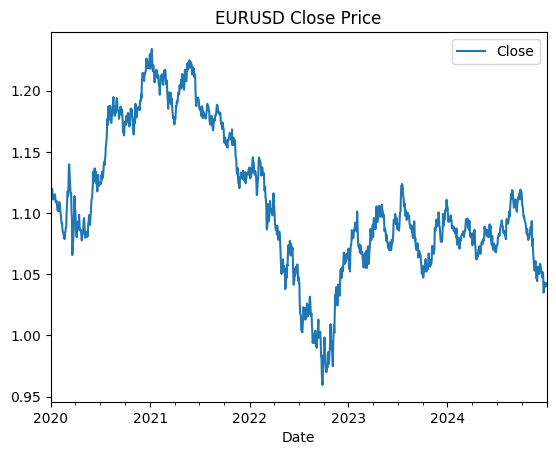

Correlation between EURUSD and Gold: -0.1456
Lag 1: p_value = 0.7605
Lag 2: p_value = 0.0000
Lag 3: p_value = 0.0000
Lag 4: p_value = 0.0000
Lag 5: p_value = 0.0000
Cointegration test: statistic=-1.6141, p_value=0.7149


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 28, 64)              │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 14, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 14, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 405,473 (1.55 MB)

 Trainable params: 405,473 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - loss: 0.2881 - mae: 0.3646 - val_loss: 0.0116 - val_mae: 0.1070
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - loss: 0.0247 - mae: 0.1260 - val_loss: 0.0077 - val_mae: 0.0869
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - loss: 0.0167 - mae: 0.1024 - val_loss: 0.0058 - val_mae: 0.0752
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0155 - mae: 0.1002 - val_loss: 0.0046 - val_mae: 0.0671
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0121 - mae: 0.0892 - val_loss: 0.0016 - val_mae: 0.0384
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0131 - mae: 0.0942 - val_loss: 0.0052 - val_mae: 0.0717
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - loss: 0.0133 - mae: 0.0935 - val_loss: 0.0032 - val_mae: 0.0560
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0119 - mae: 0.0882 - val_loss: 0.0053 - val_mae: 0.0719
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - lo

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 28, 64)              │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_12 (Bidirectional)     │ (None, 14, 256)             │         148,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_13 (Bidirectional)     │ (None, 14, 128)             │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 14, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_14 (Bidirectional)     │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 306,017 (1.17 MB)

 Trainable params: 306,017 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - loss: 0.3459 - mae: 0.4617 - val_loss: 0.0049 - val_mae: 0.0672
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0449 - mae: 0.1678 - val_loss: 0.0068 - val_mae: 0.0816
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0361 - mae: 0.1515 - val_loss: 0.0015 - val_mae: 0.0370
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0250 - mae: 0.1242 - val_loss: 0.0085 - val_mae: 0.0915
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - loss: 0.0214 - mae: 0.1180 - val_loss: 6.8567e-04 - val_mae: 0.0231
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0245 - mae: 0.1263 - val_loss: 6.8170e-04 - val_mae: 0.0239
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0178 - mae: 0.1067 - val_loss: 0.0109 - val_mae: 0.1037
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0170 - mae: 0.1018 - val_loss: 0.0015 - val_mae: 0.0370
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - 

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 30, 6)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 30, 6)          │          6,918 │ input_layer_11[0][0],  │
│ (MultiHeadAttention)      │                        │                │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 30, 6)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 30, 6)          │              0 │ dropout_23[0][0],      │
│                           │                        │                │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 30, 6)          │             12 │ add_4[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 30, 64)         │            448 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 30, 64)         │              0 │ conv1d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 30, 6)          │            390 │ dropout_24[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 30, 6)          │              0 │ layer_normalization_4… │
│                           │                        │                │ conv1d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 30, 6)          │             12 │ add_5[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_3    │ (None, 30, 6)          │          6,918 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_26 (Dropout)      │ (None, 30, 6)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 30, 6)          │              0 │ dropout_26[0][0],      │
│                           │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_6     │ (None, 30, 6)          │             12 │ add_6[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 30, 64)         │            448 │ layer_normalization_6… │
├──────────────────────

 Total params: 16,073 (62.79 KB)

 Trainable params: 16,073 (62.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - loss: 0.8465 - mae: 0.8295 - val_loss: 0.0047 - val_mae: 0.0666
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0342 - mae: 0.1477 - val_loss: 0.0057 - val_mae: 0.0734
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0336 - mae: 0.1442 - val_loss: 0.0029 - val_mae: 0.0509
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0228 - mae: 0.1206 - val_loss: 0.0058 - val_mae: 0.0744
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0225 - mae: 0.1134 - val_loss: 0.0034 - val_mae: 0.0556
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0204 - mae: 0.1137 - val_loss: 0.0062 - val_mae: 0.0766
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0193 - mae: 0.1080 - val_loss: 3.9067e-04 - val_mae: 0.0152
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0178 - mae: 0.1026 - val_loss: 0.0046 - val_mae: 0.0659
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 

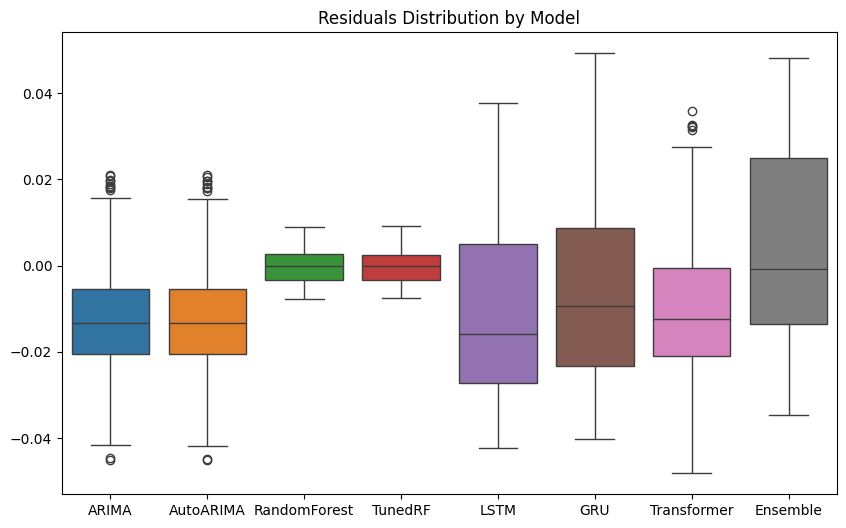

In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import yfinance as yf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import coint, grangercausalitytests
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D, GRU, Input, LayerNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, Add, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pmdarima as pm
from prophet import Prophet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
DATA_DIR = "data"

def fetch_forex_data_from_yfinance(ticker: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end)
    if df.empty:
        raise ValueError(f"No data found for ticker: {ticker}")
    df.index = pd.to_datetime(df.index)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df

def fetch_commodity_data_from_yfinance(ticker: str, start: str, end: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end)
    if df.empty:
        raise ValueError(f"No data found for ticker: {ticker}")
    df.dropna(inplace=True)
    df.index = pd.to_datetime(df.index)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df

def save_data_to_csv(df: pd.DataFrame, filename: str):
    if not os.path.exists(DATA_DIR):
        os.makedirs(DATA_DIR)
    file_path = os.path.join(DATA_DIR, filename)
    df.to_csv(file_path)

def load_data_from_csv(filename: str) -> pd.DataFrame:
    file_path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(file_path):
        return pd.DataFrame()
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    df.columns = df.columns.str.strip()
    rename_map = {col: col.split('_')[0] if ('=X' in col or '=F' in col) and '_' in col else col for col in df.columns}
    df.rename(columns=rename_map, inplace=True)
    for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=['Close'], inplace=True)
    return df

def main_data_fetching():
    try:
        eurusd_df = fetch_forex_data_from_yfinance("EURUSD=X", start="2020-01-01", end="2025-01-01")
        save_data_to_csv(eurusd_df, "EURUSD.csv")
    except Exception as e:
        print(f"Error fetching EUR/USD data: {e}")
    try:
        gold_df = fetch_commodity_data_from_yfinance("GC=F", start="2020-01-01", end="2025-01-01")
        save_data_to_csv(gold_df, "Gold.csv")
    except Exception as e:
        print(f"Error fetching Gold data: {e}")

def clean_and_preprocess_data(df: pd.DataFrame, fill_method='ffill', drop_duplicates=True,
                              remove_outliers_zscore=None, scale_method=None) -> pd.DataFrame:
    df = df.copy()
    if drop_duplicates:
        df = df[~df.index.duplicated(keep='first')]
    if fill_method in ['ffill', 'bfill']:
        df.fillna(method=fill_method, inplace=True)
    elif fill_method == 'mean':
        df.fillna(df.mean(), inplace=True)
    if remove_outliers_zscore is not None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Volume', errors='ignore')
        z_scores = np.abs(zscore(df[numeric_cols]))
        z_scores = np.nan_to_num(z_scores, nan=np.inf)
        df = df[(z_scores < remove_outliers_zscore).all(axis=1)]
    if scale_method:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if scale_method == 'standard':
            scaler = StandardScaler()
            df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
        elif scale_method == 'minmax':
            scaler = MinMaxScaler()
            df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df

def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['MA_20'] = df['Close'].rolling(window=20).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    df['RSI'] = 100 - 100 / (1 + up.ewm(com=13, adjust=False).mean() / down.ewm(com=13, adjust=False).mean())
    rolling_mean = df['Close'].rolling(window=20).mean()
    rolling_std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = rolling_mean + 2 * rolling_std
    df['Bollinger_Lower'] = rolling_mean - 2 * rolling_std
    df['MACD'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window=20).std() * np.sqrt(20)
    return df

def main_data_preprocessing():
    df = load_data_from_csv("EURUSD.csv")
    if df.empty:
        return
    df = clean_and_preprocess_data(df, fill_method='ffill', drop_duplicates=True,
                                   remove_outliers_zscore=3.0, scale_method=None)
    df = add_technical_indicators(df)
    save_data_to_csv(df, "EURUSD_features.csv")

def exploratory_data_analysis(df: pd.DataFrame, asset_name: str):
    print(df.head())
    print(df.describe())
    df.plot(y='Close', title=f"{asset_name} Close Price")
    plt.show()
    corr = df.corr()
    fig = px.imshow(corr, text_auto=True, title=f"{asset_name} Correlation Matrix")
    fig.show()

def market_analysis(df1: pd.DataFrame, df2: pd.DataFrame, col_name='Close', label1="EURUSD", label2="Gold"):
    merged = pd.DataFrame({label1: df1[col_name], label2: df2[col_name]})
    merged.dropna(inplace=True)
    print(f"Correlation between {label1} and {label2}: {merged.corr().iloc[0,1]:.4f}")
    try:
        granger_result = grangercausalitytests(merged[[label1, label2]], maxlag=5, verbose=False)
        for lag, res in granger_result.items():
            p_value = res[0]['ssr_ftest'][1]
            print(f"Lag {lag}: p_value = {p_value:.4f}")
    except Exception as e:
        print(f"Granger causality test error: {e}")
    try:
        coint_stat, p_value, _ = coint(merged[label1], merged[label2])
        print(f"Cointegration test: statistic={coint_stat:.4f}, p_value={p_value:.4f}")
    except Exception as e:
        print(f"Cointegration test error: {e}")

def main_market_analysis():
    df_eurusd = load_data_from_csv("EURUSD_features.csv")
    df_gold = load_data_from_csv("Gold.csv")
    market_analysis(df_eurusd, df_gold)

def train_test_split_time_series(df, test_size=0.2):
    split_index = int(len(df) * (1 - test_size))
    return df.iloc[:split_index].copy(), df.iloc[split_index:].copy()

def evaluate_predictions(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred), r2_score(y_true, y_pred)

def arima_model(train, test, order=(2,1,2), col_name='Close'):
    model = ARIMA(train[col_name], order=order).fit()
    return model.forecast(steps=len(test))

def auto_arima_model(train, test, col_name='Close'):
    model = pm.auto_arima(train[col_name], seasonal=False, stepwise=True, suppress_warnings=True)
    return model.predict(n_periods=len(test))

def tuned_random_forest_model(train, test, features, target='Close'):
    param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 5]}
    rf = RandomForestRegressor(random_state=42)
    grid = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(train[features], train[target])
    return grid.best_estimator_.predict(test[features])

def tuned_xgb_model(train, test, features, target='Close'):
    param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}
    xgb = XGBRegressor(random_state=42, verbosity=0)
    grid = GridSearchCV(xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(train[features], train[target])
    return grid.best_estimator_.predict(test[features])

def prophet_model(train, test, col_name='Close'):
    df_train = train[[col_name]].reset_index().rename(columns={'index': 'ds', col_name: 'y'})
    model = Prophet(daily_seasonality=True)
    model.fit(df_train)
    future = model.make_future_dataframe(periods=len(test), freq='D')
    forecast = model.predict(future)
    return forecast['yhat'].tail(len(test)).values

def prepare_sequence_data(df, features, target, window_size=30):
    X, y = [], []
    df = df.dropna(subset=features + [target])
    for i in range(window_size, len(df)):
        X.append(df[features].iloc[i-window_size:i].values)
        y.append(df[target].iloc[i])
    return np.array(X), np.array(y)

def build_advanced_lstm(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(32)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()
    return model

def deep_learning_model(train, test, features, target='Close', epochs=50, window_size=30):
    X_train, y_train = prepare_sequence_data(train, features, target, window_size)
    X_test, y_test = prepare_sequence_data(test, features, target, window_size)
    model = build_advanced_lstm((X_train.shape[1], X_train.shape[2]))
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                 ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True)]
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=1)
    preds = model.predict(X_test).flatten()
    return preds, y_test

def deep_learning_model_gru(train, test, features, target='Close', epochs=50, window_size=30):
    X_train, y_train = prepare_sequence_data(train, features, target, window_size)
    X_test, y_test = prepare_sequence_data(test, features, target, window_size)
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Bidirectional(GRU(128, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(GRU(64, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(GRU(32)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    model.summary()
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                 ModelCheckpoint('best_gru_model.keras', monitor='val_loss', save_best_only=True)]
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=1)
    preds = model.predict(X_test).flatten()
    return preds, y_test

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    x_ff = Conv1D(ff_dim, kernel_size=1, activation='relu')(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Conv1D(inputs.shape[-1], kernel_size=1)(x_ff)
    x = Add()([x, x_ff])
    return LayerNormalization(epsilon=1e-6)(x)

def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=64,
                            num_transformer_blocks=2, mlp_units=[64], dropout=0.1, mlp_dropout=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = GlobalAveragePooling1D()(x)
    for units in mlp_units:
        x = Dense(units, activation='relu')(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    model.summary()
    return model

def deep_learning_transformer_model(train, test, features, target='Close', epochs=50, window_size=30,
                                      head_size=64, num_heads=4, ff_dim=64, num_transformer_blocks=2,
                                      mlp_units=[64], dropout=0.1, mlp_dropout=0.1):
    X_train, y_train = prepare_sequence_data(train, features, target, window_size)
    X_test, y_test = prepare_sequence_data(test, features, target, window_size)
    model = build_transformer_model((X_train.shape[1], X_train.shape[2]),
                                    head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                 ModelCheckpoint('best_transformer_model.keras', monitor='val_loss', save_best_only=True)]
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, callbacks=callbacks, verbose=1)
    preds = model.predict(X_test).flatten()
    return preds, y_test

def ensemble_predictions(preds_list, weights=None):
    preds_arr = np.array(preds_list)
    if weights is None:
        weights = [1.0 / len(preds_list)] * len(preds_list)
    return np.tensordot(preds_arr, weights, axes=((0), (0)))

def main_modeling():
    df = load_data_from_csv("EURUSD_features.csv")
    if df.empty:
        return None, None, None
    features = ['MA_20', 'MA_50', 'RSI', 'MACD', 'Signal', 'Volatility']
    df = df.dropna(subset=features + ['Close'])
    train_df, test_df = train_test_split_time_series(df)
    predictions = {}
    try:
        predictions['ARIMA'] = arima_model(train_df, test_df, order=(2,1,2), col_name='Close')
    except Exception as e:
        predictions['ARIMA'] = None
    try:
        predictions['AutoARIMA'] = auto_arima_model(train_df, test_df, col_name='Close')
    except Exception as e:
        predictions['AutoARIMA'] = None
    try:
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(train_df[features], train_df['Close'])
        predictions['RandomForest'] = rf.predict(test_df[features])
    except Exception as e:
        predictions['RandomForest'] = None
    try:
        predictions['TunedRF'] = tuned_random_forest_model(train_df, test_df, features, target='Close')
    except Exception as e:
        predictions['TunedRF'] = None
    try:
        predictions['TunedXGB'] = tuned_xgb_model(train_df, test_df, features, target='Close')
    except Exception as e:
        predictions['TunedXGB'] = None
    try:
        predictions['Prophet'] = prophet_model(train_df, test_df, col_name='Close')
    except Exception as e:
        predictions['Prophet'] = None
    try:
        lstm_preds, _ = deep_learning_model(train_df, test_df, features, target='Close', epochs=50, window_size=30)
        predictions['LSTM'] = lstm_preds
        lstm_aligned_test = test_df.iloc[30:].copy()
    except Exception as e:
        predictions['LSTM'] = None
        lstm_aligned_test = test_df
    try:
        gru_preds, _ = deep_learning_model_gru(train_df, test_df, features, target='Close', epochs=50, window_size=30)
        predictions['GRU'] = gru_preds
        gru_aligned_test = test_df.iloc[30:].copy()
    except Exception as e:
        predictions['GRU'] = None
    try:
        transformer_preds, _ = deep_learning_transformer_model(train_df, test_df, features, target='Close', epochs=50, window_size=30,
                                                               head_size=64, num_heads=4, ff_dim=64, num_transformer_blocks=2,
                                                               mlp_units=[64], dropout=0.1, mlp_dropout=0.1)
        predictions['Transformer'] = transformer_preds
        transformer_aligned_test = test_df.iloc[30:].copy()
    except Exception as e:
        predictions['Transformer'] = None
    if predictions.get('RandomForest') is not None and predictions.get('TunedRF') is not None:
        rf_aligned = predictions['RandomForest'][30:]
        tuned_rf_aligned = predictions['TunedRF'][30:]
        predictions['Ensemble'] = ensemble_predictions([rf_aligned, tuned_rf_aligned], weights=[0.5, 0.5])
    eval_results = {}
    for key, preds in predictions.items():
        if preds is not None:
            if key in ['LSTM', 'GRU', 'Transformer', 'Ensemble']:
                y_true = test_df['Close'].iloc[30:]
            else:
                y_true = test_df['Close']
            eval_results[key] = evaluate_predictions(y_true, preds)
            rmse, mae, r2 = eval_results[key]
    return test_df, predictions, eval_results

def visualize_future_predictions(test_df, predictions):
    future_df = pd.DataFrame({'Date': test_df.index, 'Actual_Close': test_df['Close']})
    for model_name, preds in predictions.items():
        if preds is not None:
            min_length = min(len(preds), len(test_df))
            future_df = future_df.iloc[:min_length].copy()
            future_df[model_name + '_Predicted'] = preds[:min_length]
    future_df.set_index('Date', inplace=True)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=future_df.index, y=future_df['Actual_Close'], mode='lines', name='Actual Close', line=dict(color='black')))
    for model_name in predictions.keys():
        col = model_name + '_Predicted'
        if col in future_df.columns:
            fig.add_trace(go.Scatter(x=future_df.index, y=future_df[col], mode='lines', name=f'{model_name} Prediction'))
    df_strategy = test_df.copy()
    df_strategy['MA_20'] = df_strategy['Close'].rolling(window=20).mean()
    df_strategy['MA_50'] = df_strategy['Close'].rolling(window=50).mean()
    df_strategy['Signal'] = np.where(df_strategy['MA_20'] > df_strategy['MA_50'], 1, -1)
    df_strategy['Position'] = df_strategy['Signal'].shift(1).fillna(0)
    df_strategy['Position_Change'] = df_strategy['Position'].diff()
    buy_signals = df_strategy[df_strategy['Position_Change'] == 2]
    sell_signals = df_strategy[df_strategy['Position_Change'] == -2]
    fig.add_trace(go.Scatter(x=buy_signals.index, y=buy_signals['Close'], mode='markers', marker=dict(color='green', size=10), name='Buy Signal'))
    fig.add_trace(go.Scatter(x=sell_signals.index, y=sell_signals['Close'], mode='markers', marker=dict(color='red', size=10), name='Sell Signal'))
    fig.update_layout(title='Future Predictions & Trading Signals', xaxis_title='Date', yaxis_title='Price', hovermode='x unified')
    fig.show()

def trend_following_strategy(df: pd.DataFrame, short_window=20, long_window=50):
    df = df.copy()
    df['MA_20'] = df['Close'].rolling(window=short_window).mean()
    df['MA_50'] = df['Close'].rolling(window=long_window).mean()
    df['Signal'] = np.where(df['MA_20'] > df['MA_50'], 1, -1)
    df['Position'] = df['Signal'].shift(1).fillna(0)
    return df

def compute_var(returns, confidence=0.95):
    if len(returns) == 0:
        return np.nan
    return np.percentile(returns, (1 - confidence) * 100)

def risk_management(df: pd.DataFrame):
    df = df.copy()
    df['Daily_Return'] = df['Close'].pct_change()
    var_95 = compute_var(df['Daily_Return'].dropna(), confidence=0.95)
    return var_95

def backtest_strategy(df: pd.DataFrame, col_close='Close', position_col='Position', transaction_cost=0.0001):
    df = df.copy()
    df['Market_Return'] = df[col_close].pct_change().fillna(0)
    df['Strategy_Return'] = df[position_col] * df['Market_Return']
    df['Strategy_Return_After_Cost'] = df['Strategy_Return'] - transaction_cost * abs(df[position_col].diff().fillna(0))
    df['Cumulative_Market'] = (1 + df['Market_Return']).cumprod()
    df['Cumulative_Strategy'] = (1 + df['Strategy_Return_After_Cost']).cumprod()
    sharpe_ratio = (df['Strategy_Return_After_Cost'].mean() / df['Strategy_Return_After_Cost'].std()) * np.sqrt(252) if df['Strategy_Return_After_Cost'].std() != 0 else 0.0
    max_drawdown = (df['Cumulative_Strategy'].cummax() - df['Cumulative_Strategy']).max()
    return df, sharpe_ratio, max_drawdown

def main_backtest(test_df, predictions, eval_results):
    strat_df = trend_following_strategy(test_df)
    backtest_df, sharpe, drawdown = backtest_strategy(strat_df)
    risk_management(strat_df)
    return backtest_df

def visualization_and_reporting(test_df, predictions, eval_results, backtest_results):
    pred_df = pd.DataFrame({'Date': test_df.index, 'Actual_Close': test_df['Close']})
    for model_name, preds in predictions.items():
        if preds is not None:
            min_length = min(len(preds), len(test_df))
            pred_df = pred_df.iloc[:min_length].copy()
            pred_df[model_name + '_Predicted'] = preds[:min_length]
    pred_df.set_index('Date', inplace=True)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df['Actual_Close'], mode='lines', name='Actual'))
    for model_name in predictions.keys():
        col = model_name + '_Predicted'
        if col in pred_df.columns:
            fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df[col], mode='lines', name=model_name))
    fig.update_layout(title='Actual vs Predicted EUR/USD Prices', xaxis_title='Date', yaxis_title='Price')
    fig.show()
    residuals = {}
    for model_name in predictions.keys():
        col = model_name + '_Predicted'
        if col in pred_df.columns:
            residuals[model_name] = pred_df['Actual_Close'] - pred_df[col]
    if residuals:
        res_df = pd.DataFrame(residuals)
        plt.figure(figsize=(10,6))
        sns.boxplot(data=res_df)
        plt.title('Residuals Distribution by Model')
        plt.show()
    for model, metrics in eval_results.items():
        rmse, mae, r2 = metrics
    if backtest_results is not None:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=backtest_results.index, y=backtest_results['Cumulative_Market'], mode='lines', name='Market'))
        fig.add_trace(go.Scatter(x=backtest_results.index, y=backtest_results['Cumulative_Strategy'], mode='lines', name='Strategy'))
        fig.update_layout(title='Cumulative Returns', xaxis_title='Date', yaxis_title='Cumulative Return')
        fig.show()

def main():
    main_data_fetching()
    main_data_preprocessing()
    main_eda()
    main_market_analysis()
    test_df, predictions, eval_results = main_modeling()
    if test_df is None:
        return
    backtest_df = main_backtest(test_df, predictions, eval_results)
    visualization_and_reporting(test_df, predictions, eval_results, backtest_df)
    visualize_future_predictions(test_df, predictions)

if __name__ == "__main__":
    main()
